<font size="6">BOOSTINGs & ENSEMBLES </font>

## Необходимость методов классического машинного обучения

По словам Энтони Голдблума, основателя и генерального директора Kaggle, на соревнованиях побеждают алгоритмы, основанные на деревьях решений, и нейронные сети.

**Где побеждают ансамбли деревьев решений?**

* Recomendation systems (Netflix Prize 2009);
* Learning to rank (Yahoo Learning to rank challenge 2010);
* Crowdflower Search Results Relevance (2015);
* Avito Context Ad Clicks (2015);

 В любой задаче, где нет какой-то локальной связанности, которая есть в изображениях, текстах и других модальностях, деревья решений эффективнее чем нейронные сети.

# Ансамбли

## Корректирующий код

Пусть у нас есть сигнал:


<font color=2BA8E0 size=30>1110110011</font>

Но при передаче на другое устройство в нем могут возникать ошибки:

<font color=2BA8E0 size=30>1</font><font color=red size=30>0</font><font color=2BA8E0 size=30>1011</font><font color=red size=30>1</font><font color=2BA8E0 size=30>011</font>

Самое простое решение возникшей проблемы:

 1. Шум, который вносит ошибки, скорее всего не зависит от места в сигнале
 2. Передадим 3 раза один и тот же сигнал

<font color=2BA8E0 size=30>1</font><font color=red size=30>0</font><font color=2BA8E0 size=30>1011</font><font color=red size=30>1</font><font color=2BA8E0 size=30>011</font>

<font color=2BA8E0 size=30>1110</font><font color=red size=30>0</font><font color=2BA8E0 size=30>10011</font>

<font color=2BA8E0 size=30>11</font><font color=red size=30>0</font><font color=2BA8E0 size=30>0110</font><font color=red size=30>1</font> <font color=2BA8E0 size=30>11</font>



 3. Усредним, что получилось (в каждом случае возьмем наиболее часто встречающуюся цифру)

<font color=2BA8E0 size=30>1110110011</font>


 4. С большой долей вероятности итоговый сигнал восстановится
 5. Чем больше копий сигналов передастся, тем выше вероятность, что сигнал восстановится полностью корректно

Напишем код, чтобы удостовериться в наших выводах.

In [39]:
import numpy as np


def get_signal(size, random_state=42):
    signal = np.random.choice([0, 1], size, replace=True)
    return signal


def compare_signs(sig1, sig2):
    return (sig1 != sig2).sum()


def add_noise(sig, noise_p=0.20):
    sig = sig.copy()
    changed = np.random.choice(
        [True, False], sig.shape[0], replace=True, p=[noise_p, 1 - noise_p]
    )
    sig[changed] = 1 - sig[changed]
    return sig


def average_signals(sigs):
    sig = np.mean(sigs, axis=0)
    sig = np.round(sig, 0)
    return sig


def send_signal(signal, tries):
    passed_sigs = [add_noise(signal) for _ in range(tries)]
    fin_signal = average_signals(passed_sigs)
    return fin_signal

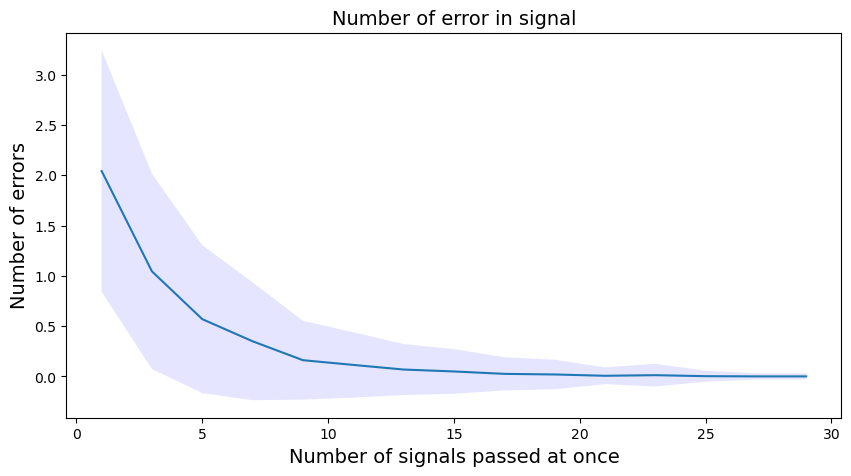

In [40]:
import matplotlib.pyplot as plt

np.random.seed(42)
repeats = 1000
signals_cnt_rng = range(1, 30, 2)

signal = get_signal(10)
mistakes = np.zeros((repeats, len(signals_cnt_rng)))

for j, sig_cnt in enumerate(signals_cnt_rng):
    for i in range(repeats):
        rec_sig = send_signal(signal, sig_cnt)
        mistakes[i, j] = compare_signs(rec_sig, signal)


mn = mistakes.mean(axis=0)
sd = mistakes.std(axis=0)
plt.figure(figsize=(10, 5))
plt.title("Number of error in signal", fontsize=14)
plt.ylabel("Number of errors", fontsize=14)
plt.xlabel("Number of signals passed at once", fontsize=14)
plt.plot(signals_cnt_rng, mn)
plt.fill_between(signals_cnt_rng, mn - sd, mn + sd, facecolor="blue", alpha=0.1)
plt.show()


Оказывается, это имеет отношение к проблеме, с которой мы столкнулись с деревьями решений.



## Усреднение предсказания классификаторов

Постановка задачи:

Есть 10 объектов, в реальности все принадлежат классу 1


<font color=2BA8E0 size=30>1111111111</font>

Пусть у нас есть три **независимых** классификатора A, B и C. Каждый предсказывает 1 в 70% случаев.


Мы хотим получить общий классификатор на основании этих трех.



Мы хотим получить предсказание базовых классификаторов и применить к ним какую-то функцию, которая выдаст итоговый ответ. Вид этой функции задается заранее.

Будем просто усреднять предсказание наших классификаторов

$$ h(x) = \dfrac 1 T \sum_{i=1}^{T}a_i(x) $$

Простое голосование

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L03/out/simple_voting.png" width="450"/>

Посчитаем вероятность того, что:

 1. Все три классификатора верны: $0.7 * 0.7 * 0.7 = 0.3429$
 2. Два классификатора верны: $0.7 * 0.7 * 0.3 + 0.7 * 0.3 * 0.7 + 0.3 * 0.7 * 0.7 = 0.4409$

Таким образом, если брать большинство голосов, то мы будем в 78% случаев предсказывать верно. Мы взяли 3 классификатора, которые сами по себе были не очень хорошими, и получили классификатор лучшего качества.
Если взять больше классификаторов, то ситуация будет еще лучше.


Пусть теперь у нас три классификатора, выдающие следующие предсказания

<font color=2BA8E0 size=30>11111111</font><font color=red size=30>00</font> — 80% точность

<font color=2BA8E0 size=30>11111111</font><font color=red size=30>00</font> — 80% точность

<font color=2BA8E0 size=30>1</font></font><font color=red size=30>0</font><font color=2BA8E0 size=30>111111</font><font color=red size=30>00</font> — 70% точность

Если объединим предсказания, то получим:

<font color=2BA8E0 size=30>11111111</font><font color=red size=30>00</font> — 80% точность

Потому что очень **высокая зависимость предсказаний**. Выше видно, что два классификатора предсказывают абсолютно одинаково. Вероятность, что они делают это случайно, очень мала.

А вот если возьмем такие классификаторы, то все получится:

<font color=2BA8E0 size=30>11111111</font><font color=red size=30>00</font> — 80% точность

<font color=red size=30>0</font><font color=2BA8E0 size=30>111</font><font color=red size=30>0</font><font color=2BA8E0 size=30>111</font><font color=red size=30>0</font><font color=2BA8E0 size=30>1</font> — 70% точность

<font color=2BA8E0 size=30>1</font><font color=red size=30>000</font><font color=2BA8E0 size=30>1</font><font color=red size=30>0</font><font color=2BA8E0 size=30>1111</font> — 60% точность


Усреднение:

<font color=2BA8E0 size=30>11111111</font><font color=red size=30>0</font><font color=2BA8E0 size=30>1</font> — 90% точность

### Зависимость качества ансамбля от качества индивидуального предсказателя и от числа предсказателей

In [41]:
def get_predictions(y_real, p, cnt):
    size = y_real.shape[0]
    guessed = np.random.choice([True, False], (cnt, size), p=[p, 1 - p])
    y = np.repeat(y_real.reshape(1, -1), cnt, axis=0)
    y[~guessed] = 1 - y[~guessed]
    return y

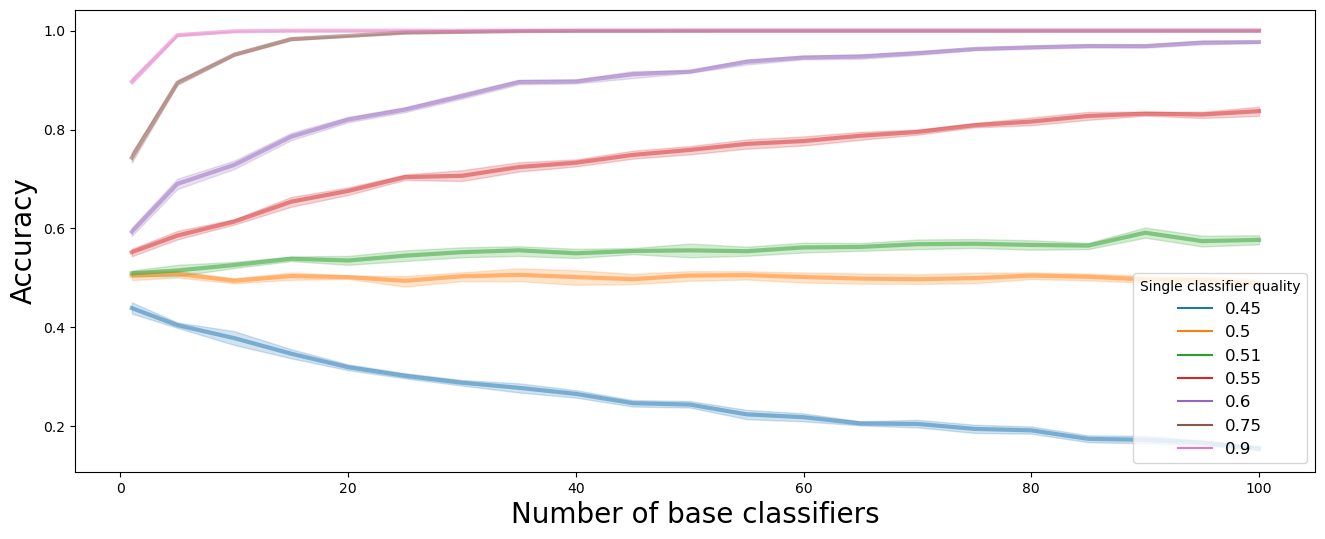

In [42]:
import pandas as pd
import seaborn as sns

size = 1000
reps = 10

cnt_base_predictors = [1] + list(range(5, 105, 5))
single_qual = [0.45, 0.5, 0.51, 0.55, 0.6, 0.75, 0.9]

dt = {"cnt": [], "single_qual": [], "accuracy": []}

for i in range(reps):
    y_real = np.random.choice([0, 1], size)
    for cnt in cnt_base_predictors:
        for p in single_qual:
            preds = get_predictions(y_real, p, cnt)
            voting = np.round(preds.mean(axis=0))
            accuracy = (y_real == voting).mean()
            dt["cnt"].append(cnt)
            dt["single_qual"].append(f"{p:.02}")
            dt["accuracy"].append(accuracy)

results = pd.DataFrame(dt)

plt.figure(figsize=(16, 6))

sns.lineplot(data=results, x="cnt", y="accuracy", hue="single_qual", lw=3, alpha=0.5)
plt.xlabel("Number of base classifiers", size=20)
plt.ylabel("Accuracy", size=20)
plt.legend(loc="best", fontsize=12, title="Single classifier quality")
plt.show()

Видим:
1. Чем лучше базовый классификатор, тем меньше нужно классификаторов при прочих равных условиях для достижения высокого качества
2. Если качество базового классификатора даже чуть больше 0.5, то качество ансамбля растет с увеличением числа моделей в ансамбле
3. Если качество базового классификатора неотличимо от случайного (0.5), то качество ансамбля будет оставаться равным 0.5
4. Если качество базового классификатора ниже случайного (0.5), то качество ансамбля стремится к 0

### Коррелированность моделей


Посмотрим, как зависит качество предсказания от коррелированности предсказателей. Конкретно — от ожидаемой коррелированности вероятностей ошибиться на данном объекте для любой взятой пары классификаторов из ансамбля.

In [43]:
import scipy


def get_correlated_predictions(y_real, p, cnt, r):
    size = y_real.shape[0]
    x1 = np.random.uniform(0, 1, size)
    x2 = np.random.uniform(0, 1, (cnt, size))
    q = np.sqrt(r)
    y = (
        q * x1 + (1 - q**2) ** 0.5 * x2
    )  # y variables now correlated with correlation=r
    y_mod = np.zeros_like(y)
    for i in range(y.shape[0]):
        y_mod[i] = scipy.stats.rankdata(y[i])

    y = y_mod / size  # back to uniform, slightly affects correlations

    y_pred = np.repeat(y_real.reshape(1, -1), cnt, axis=0)
    y_pred[y < 1 - p] = 1 - y_pred[y < 1 - p]  # to predictions, affects correlations
    return y_pred

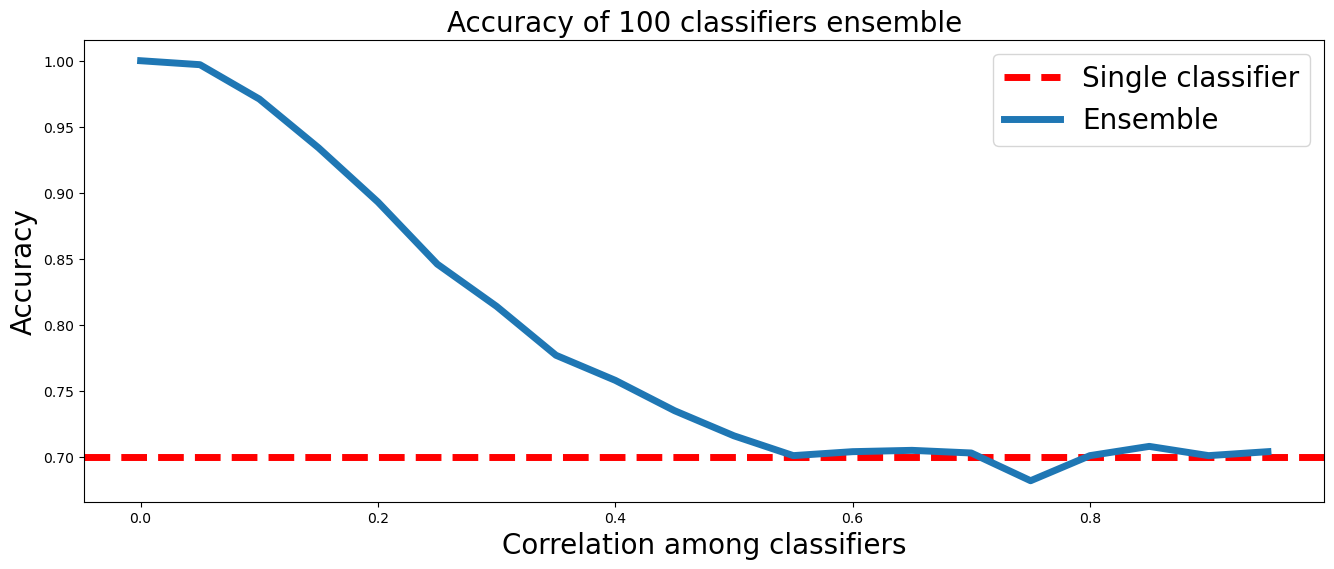

In [44]:
np.random.seed(42)
x = np.arange(0, 1, 0.05)
accuracy = np.zeros_like(x)
p = 0.7
cnt = 100
for ind, r in enumerate(x):
    preds = get_correlated_predictions(y_real, p, cnt, r)
    voting = np.round(preds.mean(axis=0))
    accuracy[ind] = (y_real == voting).mean()

plt.figure(figsize=(16, 6))
plt.title(f"Accuracy of {cnt} classifiers ensemble", size=20)
plt.xlabel("Correlation among classifiers", size=20)
plt.ylabel("Accuracy", size=20)
plt.axhline(y=p, color="red", lw=5, ls="--", label="Single classifier")
sns.lineplot(x=x, y=accuracy, lw=5, label="Ensemble")
plt.legend(fontsize=20)
plt.show()

Видим, что, по мере увеличения коррелированности моделей, качество все больше и больше приближается к качеству одной базовой модели.

## Bagging = Bootstrap aggregation

Нам нужны классификаторы, которые сами по себе предсказывают лучше, чем случайные, при этом они должны быть не коррелированы. На самом деле это нетривиальная задача: откуда нам брать классификаторы, учитывая, что у нас 1 датасет?


<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L03/out/bagging.png" width="600"/>

Первый вариант — нам поможет уже рассмотренный bootstrap:

1. Делаем из нашего исходного датасета N выборок такого же размера с повторениями.

2. На каждой **псевдовыборке** строим отдельную модель. Чтобы полученные модели были слабо зависимы, будем использовать алгоритм, который чувствителен к небольшим изменениям в выборке.

3. Получаем N слабо зависимых моделей.

4. Когда нам нужно сделать предсказание для нового объекта, делаем предсказание каждой из N моделей, а затем усредняем предсказание.

В `sklearn` для бэггинга можно использовать класс `BaggingClassifier` из `sklearn.ensemble`. Мы напишем свой код для бэггинга для большей наглядности происходящего.

### Пишем свой bagging

In [45]:
import sklearn


def get_bootstrap_sample(x, y):
    size = x.shape[0]
    poses = np.random.choice(size, size=size, replace=True)
    x_boot = x[poses]
    y_boot = y[poses]
    return x_boot, y_boot


class BaggingBinaryClassifierEnsemble:
    def __init__(self, base_classifier, ensemble_size, random_state=42):
        self.base_classifier = base_classifier
        self.ensemble_size = ensemble_size
        self.random_state = random_state
        self.ensemble = []

    def fit(self, x, y):
        np.random.seed(self.random_state)
        for est_id in range(self.ensemble_size):
            x_boot, y_boot = get_bootstrap_sample(x, y)
            model = sklearn.clone(self.base_classifier)  # create new base model
            model.fit(x_boot, y_boot)
            self.ensemble.append(model)

    def predict_proba(self, x):
        if not self.ensemble:
            raise Exception("Unfitted model")

        y_pred = 0
        for est in self.ensemble:
            y_pred += est.predict(x)
        y_pred = y_pred / self.ensemble_size
        return y_pred

    def predict(self, x):
        y_proba = self.predict_proba(x)
        y_pred = np.round(y_proba)
        return y_pred

### Классифицируем людей с больным сердцем и нет, используя bagging

Для простоты здесь и далее будем использовать параметры моделей, подобранные ранее, когда мы использовали их вне ансамбля. В данном случае это не имеет значения, но в случае разбираемых далее случайного леса и градиентного бустинга параметры подбирают **вместе** с построением ансамбля.

In [46]:
heart_dataset = pd.read_csv(
    "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/heart.csv"
)

In [47]:
from sklearn.model_selection import train_test_split

x = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"] > 0
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

svc_model = GridSearchCV(
    SVC(), {"kernel": ("linear", "rbf"), "C": [0.01, 0.1, 1, 10]}
).fit(x_train, y_train)

logr_model = GridSearchCV(
    LogisticRegression(solver="liblinear", max_iter=100000),
    {"penalty": ("l1", "l2"), "C": [0.01, 0.1, 1, 10, 100]},
).fit(x_train, y_train)

# few objects in the leaf - poor estimates of class probabilities - the model is overtraining
dt_model = GridSearchCV(
    DecisionTreeClassifier(),
    {"max_depth": [1, 3, 5, 7, 10], "min_samples_leaf": [1, 3, 5, 10]},
).fit(x_train, y_train)

Опробуем модель:

In [49]:
bagging_dt = BaggingBinaryClassifierEnsemble(
    dt_model.best_estimator_, ensemble_size=100
)

bagging_logreg = BaggingBinaryClassifierEnsemble(
    logr_model.best_estimator_, ensemble_size=100
)

bagging_svc = BaggingBinaryClassifierEnsemble(
    svc_model.best_estimator_, ensemble_size=100
)

In [50]:
bagging_dt.fit(x_train.values, y_train.values)
bagging_logreg.fit(x_train.values, y_train.values)
bagging_svc.fit(x_train.values, y_train.values)

In [51]:
y_pred_blr = bagging_logreg.predict_proba(x_test.values)
y_pred_bsvc = bagging_svc.predict_proba(x_test.values)
y_pred_bdt = bagging_dt.predict_proba(x_test.values)

In [52]:
from sklearn.metrics import average_precision_score  # PR-AUC

qual_blr = average_precision_score(y_true=y_test, y_score=y_pred_blr)
qual_bsvc = average_precision_score(y_true=y_test, y_score=y_pred_bsvc)
qual_bdt = average_precision_score(y_true=y_test, y_score=y_pred_bdt)
print(f"Bagged Logistic regression pr-auc: {qual_blr:.03f}")
print(f"Bagged SVC pr-auc: {qual_bsvc :.03f}")
print(f"Bagged DecisionTreeClassifier pr-auc: {qual_bdt:.03f}")

Bagged Logistic regression pr-auc: 0.872
Bagged SVC pr-auc: 0.900
Bagged DecisionTreeClassifier pr-auc: 0.898


In [53]:
def bootstrap_metric(x, y, metric_fn, samples_cnt=1000, alpha=0.05, random_state=42):
    size = len(x)
    np.random.seed(random_state)
    b_metric = np.zeros(samples_cnt)
    for it in range(samples_cnt):
        poses = np.random.choice(x.shape[0], size=x.shape[0], replace=True)

        x_boot = x[poses]
        y_boot = y[poses]

        m_val = metric_fn(x_boot, y_boot)
        b_metric[it] = m_val

    return b_metric

In [54]:
boot_score_blogreg = bootstrap_metric(
    y_test.values,
    y_pred_blr,
    metric_fn=lambda x, y: average_precision_score(y_true=x, y_score=y),
)
boot_score_bsvc = bootstrap_metric(
    y_test.values,
    y_pred_bsvc,
    metric_fn=lambda x, y: average_precision_score(y_true=x, y_score=y),
)
boot_score_bdt = bootstrap_metric(
    y_test.values,
    y_pred_bdt,
    metric_fn=lambda x, y: average_precision_score(y_true=x, y_score=y),
)
alpha = 0.10
print(
    "Bagged Logistic regression pr-auc 90%-ci: ",
    np.quantile(boot_score_blogreg, q=[alpha / 2, 1 - alpha / 2]),
)
print(
    "Bagged SVC pr-auc 90%-ci:",
    np.quantile(boot_score_bsvc, q=[alpha / 2, 1 - alpha / 2]),
)
print(
    "Bagged DecisionTreeClassifier pr-auc 90%-ci:",
    np.quantile(boot_score_bdt, q=[alpha / 2, 1 - alpha / 2]),
)

Bagged Logistic regression pr-auc 90%-ci:  [0.78262498 0.95069418]
Bagged SVC pr-auc 90%-ci: [0.81964811 0.97611851]
Bagged DecisionTreeClassifier pr-auc 90%-ci: [0.83053272 0.95963424]


In [55]:
y_pred1 = svc_model.decision_function(
    x_test
)  # by default, SVM gives score to each object instead of probabilities
y_pred2 = logr_model.predict_proba(x_test)[:, 1]
y_pred3 = dt_model.predict_proba(x_test)[:, 1]

qual1 = average_precision_score(y_true=y_test, y_score=y_pred1)
qual2 = average_precision_score(y_true=y_test, y_score=y_pred2)
qual3 = average_precision_score(y_true=y_test, y_score=y_pred3)

In [56]:
boot_score_logreg = bootstrap_metric(
    y_test.values,
    y_pred1,
    metric_fn=lambda x, y: average_precision_score(y_true=x, y_score=y),
)
boot_score_svc = bootstrap_metric(
    y_test.values,
    y_pred2,
    metric_fn=lambda x, y: average_precision_score(y_true=x, y_score=y),
)
boot_score_dt = bootstrap_metric(
    y_test.values,
    y_pred3,
    metric_fn=lambda x, y: average_precision_score(y_true=x, y_score=y),
)

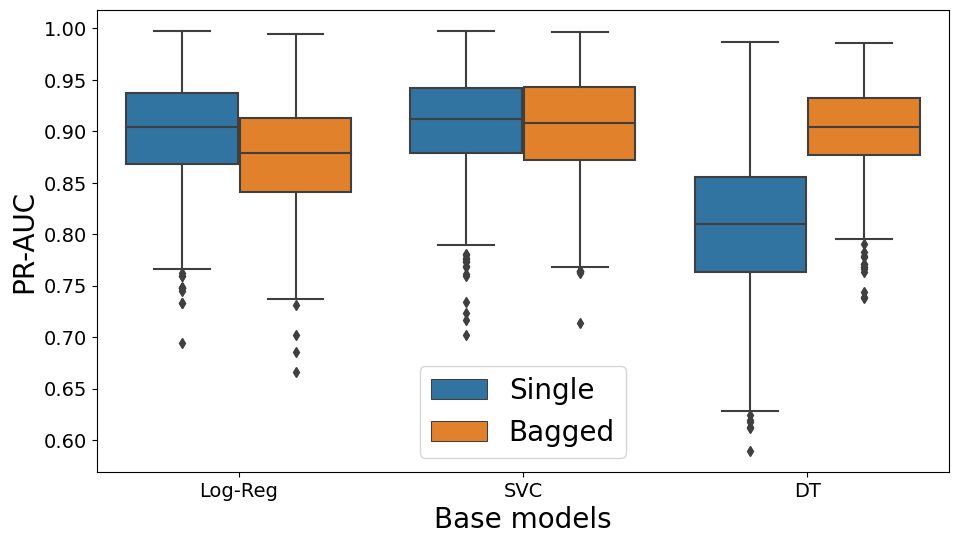

In [57]:
plt.figure(figsize=(11, 6))

result_arrays = [
    boot_score_logreg,
    boot_score_svc,
    boot_score_dt,
    boot_score_blogreg,
    boot_score_bsvc,
    boot_score_bdt,
]
base_models = ["Log-Reg", "SVC", "DT"] * 2
ensemble_types = ["Single"] * 3 + ["Bagged"] * 3

dfs = []
for i, res in enumerate(result_arrays):
    df = pd.DataFrame(res, columns=["pr_auc"])
    df["base_model"] = base_models[i]
    df["ensemble_method"] = ensemble_types[i]
    dfs.append(df)

sns.boxplot(data=pd.concat(dfs), y="pr_auc", x="base_model", hue="ensemble_method")
plt.xlabel("Base models", size=20)
plt.ylabel("PR-AUC", size=20)
plt.legend(fontsize=20)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.show()

Дереву решений — при ансамблировании удается получить качество не хуже других базовых моделей.

### Сравним разделяющие плоскости дерева решений и бэггинга на деревьях решений

In [58]:
from sklearn import datasets

x, y = sklearn.datasets.make_moons(n_samples=500, noise=0.30, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [59]:
from matplotlib.colors import ListedColormap


def plot_decision_boundary(
    clf, x, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.85, contour=True, bolded=False
):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    x_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(x_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#FEE7D0", "#bea6ff", "#B8E1EC"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#FEE7D0", "#5D5DA6", "#B8E1EC"])
        if bolded:
            custom_cmap2 = ListedColormap(["#FEE7D0", "#5D5DA6", "#000000"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2)
    plt.plot(x[:, 0][y == 0], x[:, 1][y == 0], "D", c="#F9B041", alpha=alpha)
    plt.plot(x[:, 0][y == 1], x[:, 1][y == 1], "o", c="#2DA9E1", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

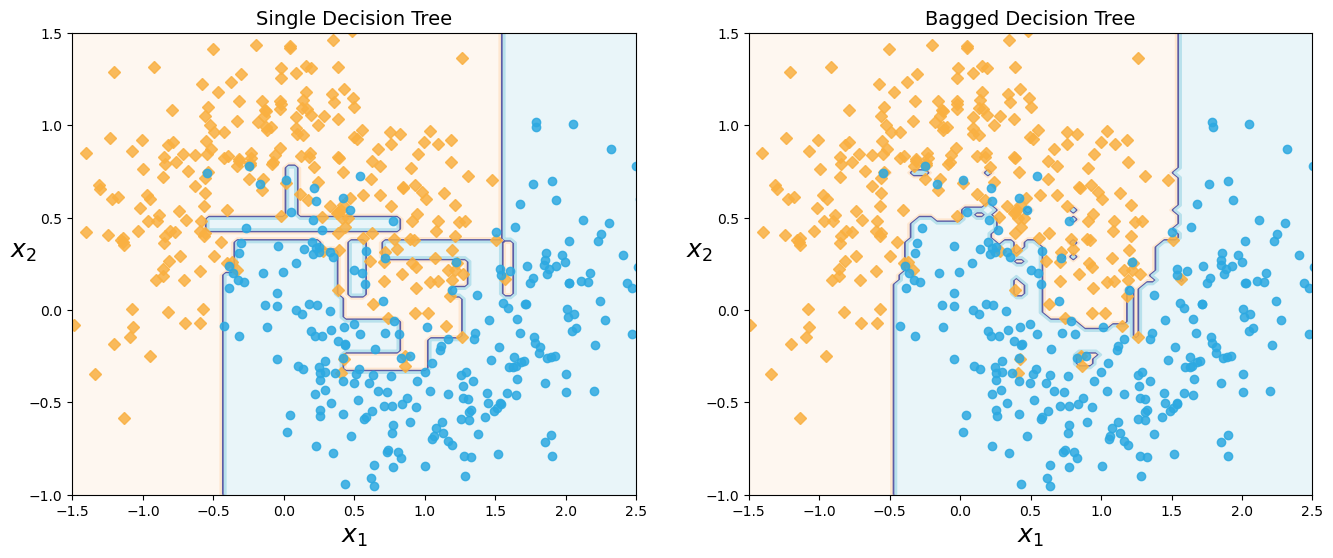

In [60]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
clf = DecisionTreeClassifier(max_depth=10, random_state=42)
clf.fit(x_train, y_train)
plot_decision_boundary(clf, x, y)
plt.title("Single Decision Tree", fontsize=14)

plt.subplot(122)
bagging_dt = BaggingBinaryClassifierEnsemble(
    DecisionTreeClassifier(max_depth=10), ensemble_size=100
)
bagging_dt.fit(x_train, y_train)
plot_decision_boundary(bagging_dt, x, y)
plt.title("Bagged Decision Tree", fontsize=14)
plt.show()

Видим, что разделяющая плоскость для дерева более гладкая и лучше отражает реальное разделение классов.

До этого мы говорили (обсуждая bias-variance trade-off), что хорошо бы взять решающие границы большого числа деревьев,
построенных на разных  тренировочных датасетах, полученных из генеральной совокупности, и усреднить эти границы, получив более хорошую решающую границу. К сожалению, мы не можем брать бесконечное число тренировочных датасетов. Но у нас есть бутстрэп. И он тоже достаточно хорошо аппроксимирует границу, которую мы бы получили, будь у нас много разных тренировочных датасетов:


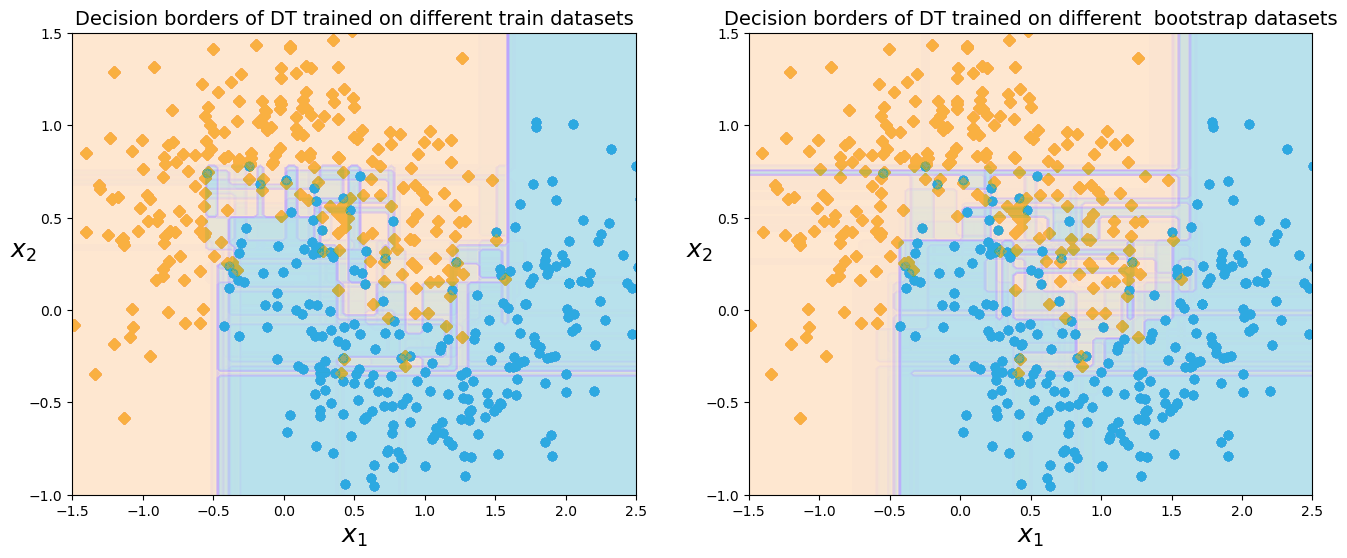

In [61]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.title("Decision borders of DT trained on different train datasets", fontsize=14)
for i in range(100):
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=i)
    clf = DecisionTreeClassifier(max_depth=20, random_state=42)
    clf.fit(x_train, y_train)
    plot_decision_boundary(clf, x, y, alpha=0.02, contour=False)

plt.subplot(122)
plt.title(
    "Decision borders of DT trained on different  bootstrap datasets", fontsize=14
)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
bagging_dt = BaggingBinaryClassifierEnsemble(
    DecisionTreeClassifier(max_depth=10), ensemble_size=100, random_state=42
)

bagging_dt.fit(x_train, y_train)

for base_dt in bagging_dt.ensemble:
    plot_decision_boundary(base_dt, x, y, alpha=0.02, contour=False)

## Метод случайных подпространств (RSM, random subspace method)

Второй вариант получения псевдовыборок — сэмплировать не объекты, а признаки.  При этом бесполезно иметь в выборке два одинаковых признака, так как потом мы делаем выборки меньшего размера, чем исходное число признаков и без повторений.

 <img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L03/out/random_subspace_method.png" width="1000"/>

Обычно для каждой модели выбирают:

 для задач классификации:

 $$\sqrt{feature\_cnt}$$

 для задач регрессии:

 $$ \frac {feature\_cnt} {3}$$

  Хотя строгих правил нет, этот параметр можно подбирать на кросс-валидации.

### Пишем свой RSM

Напишем метод случайных подпространств сами:

In [62]:
def get_rsm_sample(x, y, f_num=None):
    size = x.shape[1]
    f_num = f_num or int(np.sqrt(size)) + 1
    f_num = min(size, f_num)

    f_poses = np.random.choice(size, size=f_num, replace=False)
    x_rsm = x[:, f_poses]
    y_rsm = y.copy()
    return x_rsm, y_rsm, f_poses


class RSMBinaryClassifierEnsemble:
    def __init__(
        self, base_classifier, ensemble_size, random_state=42, max_features=None
    ):
        self.base_classifier = base_classifier
        self.ensemble_size = ensemble_size
        self.random_state = random_state
        self.max_features = max_features

        self.ensemble = []
        self.feature_poses = []
        # we had to keep track of features selected. In sklearn Random Forest, discussed below,
        # another, more stable implementation is used.
        # they use `f_num` random features but in case no good split found, they try other features too.

    def fit(self, x, y):
        np.random.seed(self.random_state)
        for est_id in range(self.ensemble_size):
            x_boot, y_boot, f_poses = get_rsm_sample(x, y, f_num=self.max_features)
            self.feature_poses.append(f_poses)
            model = sklearn.clone(self.base_classifier)  # create new base model
            model.fit(x_boot, y_boot)
            self.ensemble.append(model)

    def predict_proba(self, x):
        if not self.ensemble:
            raise Exception("Unfitted model")

        y_pred = 0
        for ind, est in enumerate(self.ensemble):
            y_pred += est.predict(x[:, self.feature_poses[ind]])
        y_pred = y_pred / self.ensemble_size
        return y_pred

    def predict(self, x):
        y_proba = self.predict_proba(x)
        y_pred = np.round(y_proba)
        return y_pred

###  Классифицируем людей с больным сердцем и нет, используя RSM

In [63]:
x = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"] > 0
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

rsm_dt = RSMBinaryClassifierEnsemble(dt_model.best_estimator_, ensemble_size=100)

rsm_logreg = RSMBinaryClassifierEnsemble(logr_model.best_estimator_, ensemble_size=100)

rsm_svc = RSMBinaryClassifierEnsemble(svc_model.best_estimator_, ensemble_size=100)

In [64]:
rsm_dt.fit(x_train.values, y_train.values)
rsm_logreg.fit(x_train.values, y_train.values)
rsm_svc.fit(x_train.values, y_train.values)

In [65]:
y_pred_rlr = rsm_logreg.predict_proba(x_test.values)
y_pred_rsvc = rsm_svc.predict_proba(x_test.values)
y_pred_rdt = rsm_dt.predict_proba(x_test.values)

In [66]:
boot_score_rlogreg = bootstrap_metric(
    y_test.values,
    y_pred_rlr,
    metric_fn=lambda x, y: average_precision_score(y_true=x, y_score=y),
)

boot_score_rsvc = bootstrap_metric(
    y_test.values,
    y_pred_rsvc,
    metric_fn=lambda x, y: average_precision_score(y_true=x, y_score=y),
)

boot_score_rdt = bootstrap_metric(
    y_test.values,
    y_pred_rdt,
    metric_fn=lambda x, y: average_precision_score(y_true=x, y_score=y),
)

alpha = 0.10
print(
    "RSM Logistic regression pr-auc 90%-ci: ",
    np.quantile(boot_score_blogreg, q=[alpha / 2, 1 - alpha / 2]),
)
print(
    "RSM SVC pr-auc 90%-ci:", np.quantile(boot_score_bsvc, q=[alpha / 2, 1 - alpha / 2])
)
print(
    "RSM DecisionTreeClassifier pr-auc 90%-ci:",
    np.quantile(boot_score_bdt, q=[alpha / 2, 1 - alpha / 2]),
)

RSM Logistic regression pr-auc 90%-ci:  [0.78262498 0.95069418]
RSM SVC pr-auc 90%-ci: [0.81964811 0.97611851]
RSM DecisionTreeClassifier pr-auc 90%-ci: [0.83053272 0.95963424]


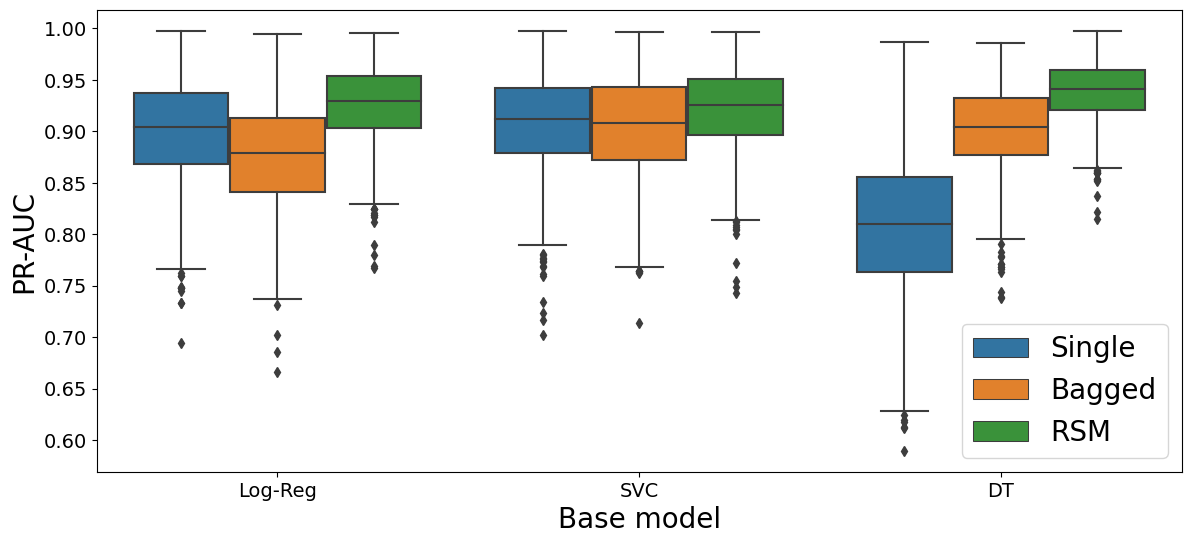

In [67]:
plt.figure(figsize=(14, 6))

result_arrays = [
    boot_score_logreg,
    boot_score_svc,
    boot_score_dt,
    boot_score_blogreg,
    boot_score_bsvc,
    boot_score_bdt,
    boot_score_rlogreg,
    boot_score_rsvc,
    boot_score_rdt,
]
base_models = ["Log-Reg", "SVC", "DT"] * 3
ensemble_types = ["Single"] * 3 + ["Bagged"] * 3 + ["RSM"] * 3

dfs = []
for i, res in enumerate(result_arrays):
    df = pd.DataFrame(res, columns=["pr_auc"])
    df["base_model"] = base_models[i]
    df["ensemble_method"] = ensemble_types[i]
    dfs.append(df)

sns.boxplot(data=pd.concat(dfs), y="pr_auc", x="base_model", hue="ensemble_method")
plt.xlabel("Base model", size=20)
plt.ylabel("PR-AUC", size=20)
plt.legend(fontsize=20)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.show()

RSM значительно помогает только дереву решений. Остальные методы почти не улучшают своего качества.

## Комбинация RSM и Bagging

Можно объединить оба способа: применяем bootstrap к объектам (получается выборка одного размера, но с повторяющимися объектами, а каких-то объектов не будет), и, кроме этого, выкидываем часть признаков. В этом случае мы получим еще более сильно отличающиеся друг от друга случайные выборки.

`sklearn.ensemble.BaggingClassifier` и `sklearn.ensemble.BaggingRegressor` вопреки названию может поддерживать оба способа.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L03/out/rsm_and_bagging.png" width="300"/>

### Почему для одних классов моделей работает, а для других — нет

Теперь будем использовать `BaggingClassier` из стандартной библиотеки:

In [68]:
from sklearn.ensemble import BaggingClassifier

models = {}

logr_model = GridSearchCV(
    LogisticRegression(solver="liblinear", max_iter=100000),
    {"penalty": ("l1", "l2"), "C": [0.01, 0.1, 1, 10, 100]},
).fit(x_train, y_train)
models["LogReg"] = logr_model

svc_model = GridSearchCV(
    SVC(), {"kernel": ("linear", "rbf"), "C": [0.01, 0.1, 1, 10]}
).fit(x_train, y_train)
models["SVC"] = svc_model

# few objects in the leaf - poor estimates of class probabilities - the model is overtraining
dt_model = GridSearchCV(
    DecisionTreeClassifier(),
    {"max_depth": [1, 3, 5, 7, 10], "min_samples_leaf": [1, 3, 5, 10]},
).fit(x_train, y_train)
models["DT"] = dt_model

bagging_logr = BaggingClassifier(
    logr_model.best_estimator_, n_estimators=100, random_state=42
)
models["Bagging LogReg"] = bagging_logr

bagging_svc = BaggingClassifier(
    svc_model.best_estimator_, n_estimators=100, random_state=42
)
models["Bagging SVC"] = bagging_svc

bagging_dt = BaggingClassifier(
    dt_model.best_estimator_, n_estimators=100, random_state=42
)
models["Bagging DT"] = bagging_dt

sqrt_features = int(np.sqrt(x.shape[1])) + 1

rsm_logreg = BaggingClassifier(
    logr_model.best_estimator_,
    n_estimators=100,
    bootstrap=False,
    max_features=sqrt_features,
    random_state=42,
)
models["RSM LogReg"] = rsm_logreg

rsm_svc = BaggingClassifier(
    svc_model.best_estimator_,
    n_estimators=100,
    bootstrap=False,
    max_features=sqrt_features,
    random_state=42,
)
models["RSM SVC"] = rsm_svc

rsm_dt = BaggingClassifier(
    dt_model.best_estimator_,
    n_estimators=100,
    bootstrap=False,
    max_features=sqrt_features,
    random_state=42,
)
models["RSM DT"] = rsm_dt

# Both Bagging and RSM
bag_rsm_logreg = BaggingClassifier(
    logr_model.best_estimator_,
    n_estimators=100,
    bootstrap=True,
    max_features=sqrt_features,
    random_state=42,
)
models["BagRSM LogReg"] = bag_rsm_logreg


bag_rsm_svc = BaggingClassifier(
    svc_model.best_estimator_,
    n_estimators=100,
    bootstrap=True,
    max_features=sqrt_features,
    random_state=42,
)
models["BagRSM SVC"] = bag_rsm_svc

bag_rsm_dt = BaggingClassifier(
    dt_model.best_estimator_,
    n_estimators=100,
    bootstrap=True,
    max_features=sqrt_features,
    random_state=42,
)
models["BagRSM DT"] = bag_rsm_dt

In [69]:
for name, model in models.items():
    model.fit(x_train, y_train)

In [70]:
predictions = {}

for name, model in models.items():
    if name != "SVC":
        y_pred = model.predict_proba(x_test)[:, 1]
    else:
        y_pred = model.decision_function(x_test)
    predictions[name] = y_pred

In [71]:
boot_scores = {}

for name, y_pred in predictions.items():
    boot_score = bootstrap_metric(
        y_test.values,
        y_pred,
        metric_fn=lambda x, y: average_precision_score(y_true=x, y_score=y),
    )
    boot_scores[name] = boot_score

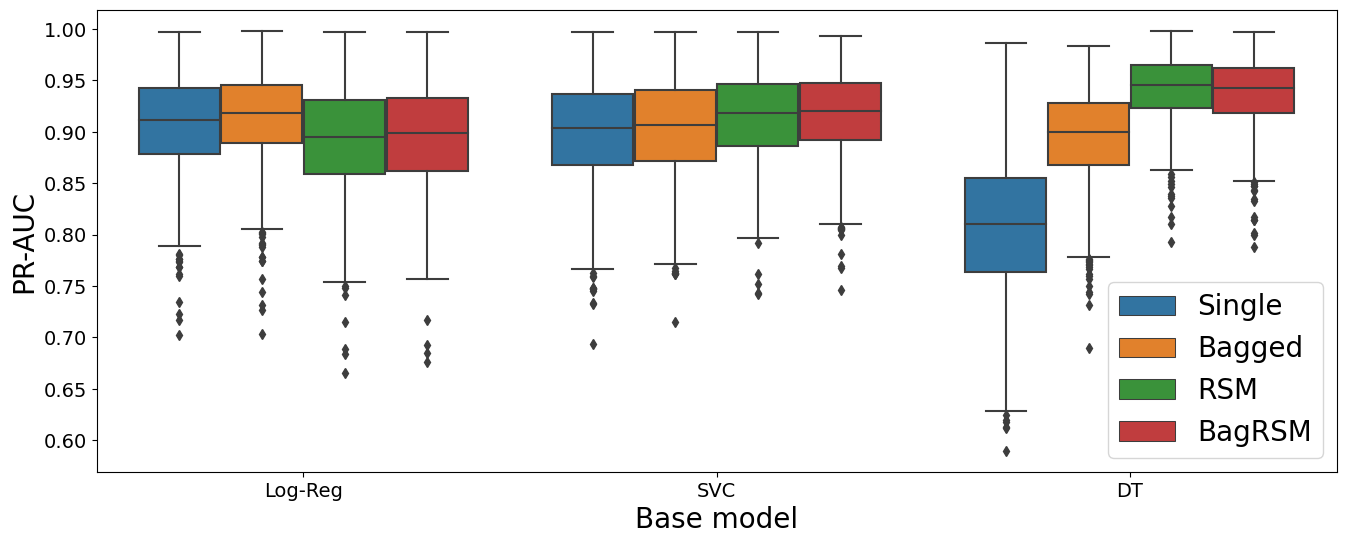

In [72]:
plt.figure(figsize=(16, 6))

base_models = ["Log-Reg", "SVC", "DT"] * 4
ensemble_types = ["Single"] * 3 + ["Bagged"] * 3 + ["RSM"] * 3 + ["BagRSM"] * 3

dfs = []
for i, model_name in enumerate(boot_scores):
    df = pd.DataFrame(boot_scores[model_name], columns=["pr_auc"])
    df["base_model"] = base_models[i]
    df["ensemble_method"] = ensemble_types[i]
    dfs.append(df)

sns.boxplot(data=pd.concat(dfs), y="pr_auc", x="base_model", hue="ensemble_method")
plt.xlabel("Base model", size=20)
plt.ylabel("PR-AUC", size=20)
plt.legend(fontsize=20, loc="lower right")
plt.tick_params(axis="both", which="major", labelsize=14)
plt.show()

Существенное улучшение качества наблюдается только при использовании решающего дерева в качестве базовой модели.

Чтобы простое голосование повышало качество ансамбля, необходимо, чтобы ошибки базовых моделей не коррелировали между собой.

Попробуем оценить попарную корреляцию в ошибках базовых моделей в ансамблях.

In [73]:
import itertools


def base_model_pair_correlation(ensemble, x):
    corrs = []
    for (i, est1), (j, est2) in itertools.combinations(
        enumerate(ensemble.estimators_), 2
    ):
        xi_test = x.values[:, ensemble.estimators_features_[i]]
        xj_test = x.values[:, ensemble.estimators_features_[j]]

        if not isinstance(est1, sklearn.svm.SVC):
            y_pred_t1 = est1.predict_proba(xi_test)[:, 1]

            y_pred_t2 = est2.predict_proba(xj_test)[:, 1]
        else:
            y_pred_t1 = est1.decision_function(xi_test)
            xj_test = x_test.values[:, ensemble.estimators_features_[j]]
            y_pred_t2 = est2.decision_function(xj_test)
        corrs.append(scipy.stats.pearsonr(y_pred_t1, y_pred_t2)[0])
    return np.array(corrs)

In [ ]:
pair_correlations = {}
for name, model in models.items():
    if not "Bagging" in name and not "RSM" in name:
        continue
    pair_correlations[name] = base_model_pair_correlation(model, x_test)

In [ ]:
cor_res = pd.DataFrame(pair_correlations)
cor_res = cor_res.melt(
    value_vars=cor_res.columns, value_name="paircor", var_name="model"
)


# get base models and ensembling methods from names
def read_base(s):
    if "dt" in s.lower():
        return "DT"
    elif "svc" in s.lower():
        return "SVC"
    else:
        return "Log-Reg"


def read_ensemble(s):
    bag, rsm = False, False
    if "bag" in s.lower():
        bag = True
    if "rsm" in s.lower():
        rsm = True
    if bag and rsm:
        return "BagRSM"
    if bag:
        return "Bagged"
    if rsm:
        return "RSM"
    return "Single"


cor_res["base_model"] = cor_res["model"].apply(read_base)
cor_res["ensemble_method"] = cor_res["model"].apply(read_ensemble)

Кроме того, посчитаем качество базовых моделей, входящих в каждый из ансамблей.

In [ ]:
def base_model_prauc(ensemble, x, y):
    qual = np.zeros(ensemble.n_estimators)
    for ind, est in enumerate(ensemble.estimators_):
        x_test = x.values[:, ensemble.estimators_features_[i]]
        if not isinstance(est, sklearn.svm.SVC):
            y_pred = est.predict_proba(x_test)[:, 1]
        else:
            y_pred = est.decision_function(x_test)
        qual[ind] = average_precision_score(y_score=y_pred, y_true=y)
    return qual

In [ ]:
base_prauc = {}
for name, model in models.items():
    if not "Bagging" in name and not "RSM" in name:
        continue
    base_prauc[name] = base_model_prauc(model, x_test, y_test)

In [ ]:
base_prauc_res = pd.DataFrame(base_prauc)
base_prauc_res = base_prauc_res.melt(
    value_vars=base_prauc_res.columns, value_name="pr_auc", var_name="model"
)
base_prauc_res["base_model"] = base_prauc_res["model"].apply(read_base)
base_prauc_res["ensemble_method"] = base_prauc_res["model"].apply(read_ensemble)

In [ ]:
plt.figure(figsize=(16, 12))
plt.subplot(211)
sns.boxplot(data=cor_res, y="paircor", x="base_model", hue="ensemble_method")
plt.title("Pairwise correlations in ensembles", size=25)
plt.xlabel("", size=20)
plt.ylabel("Pairwise correlation", size=20)
plt.legend(fontsize=20, loc="lower left")
plt.tick_params(axis="both", which="major", labelsize=14)

plt.subplot(212)
sns.boxplot(data=base_prauc_res, y="pr_auc", x="base_model", hue="ensemble_method")
plt.title("Base model quality", size=25)
plt.xlabel("", size=20)
plt.ylabel("PR-AUC", size=20)
plt.subplots_adjust()
plt.legend(fontsize=20, loc="lower left")
plt.tick_params(axis="both", which="major", labelsize=14)
plt.show()

Можно сделать следующие выводы:

1. Bagging, RSM и их комбинация помогают уменьшать корреляцию между базовыми моделями. Причем, комбинация Bagging и RSM работают лучшее, чем каждый из них поодиночке;
2. В случае просто Bagging, дерево решений получает существенный прирост качества за счет того, что модели на его основе коррелированы значительно слабее, чем модели на основе логистической регрессии и метода опорных векторов;
3. В остальных случаях корреляция моделей на основе деревьев решений все равно немного ниже, чем у других моделей, а качество базовых моделей сравнимо. Из-за этого ансамбль на основе деревьев решений опять показывает лучший результат.

## Случайный лес

Из предыдущей части мы увидели, что использование bagging или RSM для SVM или подобных моделей не несет большого смысла.


Но для деревьев решений это не так. Будем брать деревья большой глубины.  Незначительные изменения в данных приводят к значительным  изменениям в топологии таких деревьев. Таким образом, мы приходим к **случайному лесу** = Bagging + RSM над деревом решений.

При этом RSM в классическом случайном лесе делается не на уровне дерева, а на уровне узла. В каждом узле дерева, когда мы выбираем лучшее разбиение его на два дочерних, мы просматриваем не все признаки, а только определенное их количество.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L03/out/random_forest.png" width="900"/>

Случайный лес работает лучше, чем отдельно случайно взятое дерево. Но главное, что случайный лес намного более устойчив к шуму.
Это свойство до сих пор позволяет случайному лесу успешно использоваться в областях с шумными данными.

### Зависимость качества случайного леса от числа деревьев
Для случайного леса верно следующее: когда мы берем множество базовых классификаторов (в данном случае деревьев) и усредняем их, то **результат этих усреднений стремится к идеальному дереву решений**, причем построенному на идеальных, а не на исходных признаках.

Проверим это на задаче регрессии [California Housing dataset](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset)

In [ ]:
calif_housing = sklearn.datasets.fetch_california_housing()
x = calif_housing.data
y = calif_housing.target
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

Данные — средние характеристики квартиры в доме. Цель — предсказать цену на дом.

Создадим несколько случайных лесов с различным количеством деревьев и простое дерево решений для сравнения с ним (baseline).

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

models_rf = {}

# add single decision tree for comparison
models_rf["DT"] = GridSearchCV(
    DecisionTreeRegressor(),
    {"max_depth": [1, 3, 5, 7, 10], "min_samples_leaf": [1, 3, 5, 10]},
)

# this can be done faster, see warm_start parameter for this
# (https://stackoverflow.com/questions/42757892/how-to-use-warm-start)
for n_estimators in [3, 5, 10, 50, 100, 150, 250]:
    models_rf[f"RF{n_estimators}"] = RandomForestRegressor(
        n_estimators=n_estimators, random_state=42, n_jobs=-1
    )  # run in parallel

Обучим все модели.
Для этого напишем вспомогательную функцию, которая будет обучать переданные ей модели и считать для них качество на тесте.

In [ ]:
from sklearn.metrics import mean_squared_error


def train_and_test_regressor(models, x_train, y_train, x_test, y_test, verb=True):
    boot_scores = {}
    for name, model in models.items():
        model.fit(x_train, y_train)  # train the model
        y_pred = model.predict(x_test)  # get predictions
        boot_scores[name] = bootstrap_metric(  # calculate bootstrap score
            y_test,
            y_pred,
            metric_fn=lambda x, y: mean_squared_error(y_true=x, y_pred=y),
        )
        if verb:
            print(f"Fitted {name} with bootstrap score {boot_scores[name].mean():.3f}")

    results = pd.DataFrame(boot_scores)
    # cast to long format https://pandas.pydata.org/docs/reference/api/pandas.melt.html
    results = results.melt(
        value_vars=results.columns, value_name="mse", var_name="model"
    )
    return results


results_rf = train_and_test_regressor(models_rf, x_train, y_train, x_test, y_test)

In [ ]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=results_rf, y="mse", x="model")
plt.ylabel("MSE", size=20)
plt.xlabel("Models", size=20)
plt.title("Number of estimators vs MSE", size=20)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.show()

Увеличение числа базовых моделей сначала сильно улучшает качество модели. Однако после определенного количества базовых моделей улучшение качества становится незначительным.

### Зависимость качества случайного леса от глубины дерева

Чем больше глубина дерева, тем большая нескорелированность базовых моделей будет получаться. В общем случае в случайном лесе важно использовать именно глубокие деревья, причем в большинстве случаев их глубину не надо ограничивать (или ограничивать большими значениями порядка 10-12).

Помимо этого, будем добавлять кроме случайного леса с заданной глубиной еще одиночное дерево такой же глубины.

In [ ]:
dt_depth = {}
rf_depth = {}

for depth in range(1, 20, 2):
    dt_depth[depth] = DecisionTreeRegressor(max_depth=depth, random_state=42)

    rf_depth[depth] = RandomForestRegressor(
        n_estimators=100, max_depth=depth, random_state=42, n_jobs=-1
    )  # run in parallel

dt_res = train_and_test_regressor(
    dt_depth, x_train, y_train, x_test, y_test, verb=False
)
rf_res = train_and_test_regressor(
    rf_depth, x_train, y_train, x_test, y_test, verb=False
)

dt_res = dt_res.rename(columns={"model": "tree_depth"})
rf_res = rf_res.rename(columns={"model": "tree_depth"})
dt_res["model"] = "DT"
rf_res["model"] = "RF"
depth_res = pd.concat((dt_res, rf_res))

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=depth_res, x="tree_depth", y="mse", hue="model")
plt.xlabel("Tree depth", size=20)
plt.ylabel("MSE", size=20)
plt.title("Tree depth vs MSE", size=20)
plt.legend(fontsize=20)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.show()

Лучшие результаты показывает случайный лес из наиболее глубоких деревьев.

Качество случайного леса с малой глубиной дерева не отличается от качества одиночного дерева той же глубины. Это связано с тем, что деревья малой глубины слабо отличаются друг от друга (высокий bias и низкий variance), потому усреднение их предсказаний почти не улучшает качество.

Отметим, что в случае малых выборок ограничения на глубину дерева могут дать выигрыш.

### Минимальное число объектов в листе
Иногда качество случайного леса можно улучшить, если поставить небольшое ограничение на минимальное число объектов в листе, чтобы запретить явно переобученные деревья.

In [ ]:
dt_models_min_samples = {}
rf_models_min_samples = {}

for mn_sm in [1, 3, 5, 7, 10]:
    dt_models_min_samples[mn_sm] = DecisionTreeRegressor(
        max_depth=None, min_samples_leaf=mn_sm, random_state=42
    )

    rf_models_min_samples[mn_sm] = RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        min_samples_leaf=mn_sm,
        random_state=42,
        n_jobs=-1,
    )  # run in parallel

dt_results_mn_samples = train_and_test_regressor(
    dt_models_min_samples, x_train, y_train, x_test, y_test
)
rf_results_mn_samples = train_and_test_regressor(
    rf_models_min_samples, x_train, y_train, x_test, y_test
)

dt_results_mn_samples = dt_results_mn_samples.rename(columns={"model": "min_samples"})
rf_results_mn_samples = rf_results_mn_samples.rename(columns={"model": "min_samples"})
dt_results_mn_samples["model"] = "DT"
rf_results_mn_samples["model"] = "RF"
leaf_res = pd.concat((dt_results_mn_samples, rf_results_mn_samples))

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=leaf_res, x="min_samples", y="mse", hue="model")
plt.xlabel("Min samples in leaf", size=20)
plt.ylabel("MSE", size=20)
plt.title("Min samples in leaf vs MSE", size=20)
plt.legend(fontsize=20)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.show()

В данном случае, однако, ограничение на количество объектов в листе ухудшает качество ансамбля. Одна из причин заключается в том, что с увеличением числа ограничений на дерево уменьшается непохожесть деревьев друг на друга, и качество случайного леса так же начинает уменьшаться.

### Переобучается ли случайный лес?

Существует мнение, что случайный лес не переобучается. Это не так. Можно подобрать такие два набора параметров, что первый даст лучшее качество на тренировочной выборке, а второй — на тестовой. При этом увеличение числа деревьев в ансамбле с этим справиться поможет слабо.

Возьмем, к примеру, наш синтетический пример на плоскости.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

x, y = sklearn.datasets.make_moons(n_samples=500, noise=0.30, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
plt.figure(figsize=(16, 6))
plt.subplot(121)

clf = DecisionTreeClassifier(max_depth=10, random_state=42)
clf.fit(x_train, y_train)
plot_decision_boundary(clf, x, y)
plt.title("Single Decision Tree", fontsize=14)

plt.subplot(122)
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(x_train, y_train)
plot_decision_boundary(rf, x, y)
plt.title("Random forest", fontsize=14)
plt.show()

Видны области, в которых случайный лес переобучился.

Добавление ограничения на число объектов в листьях улучшает ситуацию.

In [ ]:
plt.figure(figsize=(16, 6))

plt.subplot(121)
rf1 = RandomForestClassifier(n_estimators=1000)
rf1.fit(x_train, y_train)
plot_decision_boundary(rf1, x, y)
plt.title("Random forest", fontsize=14)

plt.subplot(122)
rf2 = RandomForestClassifier(n_estimators=1000, min_samples_leaf=5)
rf2.fit(x_train, y_train)
plot_decision_boundary(rf2, x, y)
plt.title("Random forest, min_samples_leaf=5", fontsize=14)
plt.show()

Лес без ограничения на минимальное число объектов в листе переобучился — достиг максимального качества на обучающей выборке, но на тестовой имеет качество ниже, чем лес с ограничением.

In [ ]:
y_score = rf1.predict(x_train)
q = average_precision_score(y_true=y_train, y_score=y_score)
print(f"RF1 Train: {q:.02}")
y_score = rf1.predict(x_test)
q = average_precision_score(y_true=y_test, y_score=y_score)
print(f"RF1 Test: {q:.02}")

y_score = rf2.predict(x_train)
q = average_precision_score(y_true=y_train, y_score=y_score)
print(f"RF2 Train: {q:.02}")
y_score = rf2.predict(x_test)
q = average_precision_score(y_true=y_test, y_score=y_score)
print(f"RF2 Test: {q:.02}")

### Валидиация случайного леса на Out-Of-Bag (OOB) объектах

Благодаря механизму обучения случайного леса у нас появляется еще один способ валидировать модель. Для каждого дерева используются не все объекты нашей выборки, тогда мы можем получать предсказания деревьев на объектах, которые не использовались для обучения этих деревьев.



<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L03/out/oob_rf.png" width="800">

За это отвечает параметр `oob_score` (по умолчанию `False`)

In [ ]:
from sklearn.model_selection import cross_validate

rf_oob = RandomForestClassifier(n_estimators=1000, min_samples_leaf=5, oob_score=True)
rf_oob.fit(x, y)
print(f"RF OOB score: {rf_oob.oob_score_:.02}")

scores = cross_validate(rf_oob, x, y, cv=5)
print(f"RF CV score: {scores['test_score'].mean():.02}")

rf_oob.fit(x_train, y_train)
print(f"RF Test set score: {rf_oob.score(x_test, y_test):.02}")

Важно понимать, что OOB score не заменяет другие способы валидации, а является дополнительным способом, который используется, в основном, когда данных мало.

### Случайный лес и bias-variance tradeoff
Случайный лес — инструмент для уменьшения variance нашей модели. Можно показать, что при стремлении числа моделей в ансамбле к бесконечности, а их коррелированности — к 0, variance ансамбля стремится к нулю. Однако при этом bias ансамбля будет равен bias базовой модели.

Продемонстрируем это:

In [ ]:
plt.figure(figsize=(16, 8))

# Decision trees
for i, max_depth in enumerate([1, 3, 5, 12]):
    plt.subplot(241 + i)
    dt = DecisionTreeClassifier(max_depth=max_depth)
    dt.fit(x_train, y_train)
    plot_decision_boundary(dt, x, y, alpha=0.5, bolded=True)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title(f"Decision tree, max_depth={max_depth}", fontsize=14)
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks([], [])
    plt.yticks([], [])

# Random forests
for i, max_depth in enumerate([1, 3, 5, 12]):
    plt.subplot(245 + i)
    rf = RandomForestClassifier(max_depth=max_depth, n_estimators=500, n_jobs=-1)
    rf.fit(x_train, y_train)
    plot_decision_boundary(rf, x, y, alpha=0.5, bolded=True)
    plt.title(f"Random forest, max_depth={max_depth}", fontsize=14)
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks([], [])
    plt.yticks([], [])

Видим, что общая сложность решающей границы меняется не сильно: bias случайного леса по сравнению с bias дерева решений не меняется.
А вот гладкость границы увеличивается, тем самым, уменьшается variance

## Boosting

Бустинг — это еще один способ ансамблирования моделей. В отличие от случайного леса, где каждая модель в ансамбле строится независимо, в бустинге построение очередной модели зависит от уже состоящих в ансамбле. Каждая следующая модель в ансамбле стремится улучшить предсказание всего ансамбля.

Бустинг позволяет нам на основе большого числа "слабых" моделей получить одну "сильную". Под слабыми моделями подразумеваем модели, точность которых может быть лишь немногим выше случайного угадывания.

В качестве моделей традиционно используются деревья решений, но не большой глубины, а наоборот — маленькой, чтобы каждое из них не могло выучить выборку хорошо.








<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L03/out/join_weak_learners.png" width="650"/>

Из всех бустингов больше всего прославился и доказал свою эфективность **градиентный бустинг**. Он позволяет получить решение, которое сложно побить другими видами моделей.



## Gradient boosting (градиентный бустинг)

Начнем с интуиции. Предположим, что мы играем в гольф. Наша задача — загнать мячик в лунку, причем, когда мячик далеко от нее, мы можем ударить посильнее, чтобы сократить расстояние, но когда мы уже близко к лунке, то стараемся бить клюшкой аккуратнее, чтобы не промахнуться. После каждого удара мы оцениваем расстояние до лунки и приближаем мячик в ее сторону. Применительно к нашей теме удар клюшкой по мячику — это каждая модель в градиентном бустинге.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L03/out/summarize_predictions_of_ensemble_models.png" width="650"/>

Цель $i$-той модели в ансамбле — скорректировать ошибки предыдущих ${i-1}$ моделей. В результате, когда мы суммируем вклады всех моделей ансамбля, получается хорошее предсказание.

[Демонстрация понимания интуиции градиентного бустинга](https://colab.research.google.com/drive/1hILdJzsuAsXabA4aIwtb9RGgUn_bvhCL#scrollTo=vJUevvJlS8LR)

Давайте формализуем, что нам нужно, чтобы обучить алгоритм градиентного бустинга:

- набор данных $\left\{\left(x_i, y_i\right)\right\}_{i=1, \ldots, n}$
- число итераций $M$ (оно же количество моделей)
- выбор дифференцируемой функции потерь $L(y, f)$
- выбор семейства функций базовых алгоритмов $h(x, \theta)$ с процедурой их обучения.

Минимизировать ошибку будем с помощью градиентного спуска.


<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L03/out/gradient_boosting.png" width="600"/>

Рзаберем пошагово:

Начинаем с первого предсказания, можем выбрать на самом деле любое число, например среднее значение

$$ \large \hat{f}(x)=\hat{f}_0, \hat{f}_0=\gamma, \gamma \in \mathbb{R}
 \tag{1}$$

Либо подобрать с наименьшей ошибкой

$$\large \hat{f}_0=\underset{\gamma}{\arg \min } \sum_{i=1}^n L\left(y_i, \gamma\right) $$

Посмотрим на графике, как бы могла выглядеть наша зависимость. Посчитаем ошибку и отобразим наше предсказание.





<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L03/out/gb_explanation_step1.png" width="700"/>

В нашем примере мы видим, что нужно двигаться вправо, чтобы уменьшить ошибку. В действительности мы этого не знаем, но можем посчитать градиент и узнать направление возрастания функции ошибки. Нас же интересует обратное направление или градиент со знаком минус (антиградиент).

$\large r_{i t}=-\frac{\partial L\left(y_i, f\left(x_i\right)\right)}{\partial f\left(x_i\right)} \quad \tag{2}$

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L03/out/gb_explanation_step2.png" width="700"/>

Строим новый базовый алгоритм $h_t(x)$, который обучается на то, чтобы уменьшить ошибку от текущего состояния ансамбля, и в качестве целевой переменной для него берем антиградиент функции потерь  $\left\{\left(x_i, r_{i t}\right)\right\}_{i=1, \ldots, n}$

$$\large\underset{\theta}{\arg \min } \sum_{i=1}^n L\left(h(x_i, \theta), r_{it}\right) \tag{3}$$

Подбираем оптимальный параметр $\large \rho$. Этот параметр будет разным у каждого дерева в нашем ансамбле, в отличие от learning rate:

 $$\large \rho_t=\underset{\rho}{\arg \min } \sum_{i=1}^n L\left(y_i, \hat{f}\left(x_i\right)+\rho \cdot h\left(x_i, \theta\right)\right) \tag{4}$$

Сдвигаем предсказание в сторону уменьшения ошибки, где $\lambda$ — это наш learning rate:

 $$\large \hat{f}_t(x)= \lambda \cdot \rho_t \cdot h_t(x) \tag{5}$$

Обновляем текущее приближение $\hat{f}(x)$:
$$ \large
\hat{f}(x) \leftarrow \hat{f}(x)+\hat{f}_t(x)=\sum_{i=0}^t \hat{f}_i(x) \tag{6}
$$

Далее повторяем шаги 2–6, пока не получим требуемое качество, и собираем итоговый ансамбль $\hat{f}(x)$:

$$
\large
\hat{f}(x)=\sum_{i=0}^M \hat{f}_i(x)
$$

[Подробнее о градиентном бустинге](https://habr.com/ru/company/ods/blog/327250/)

Когда мы говорили про базовые модели то предполагали, что этими базовыми моделями являются деревья решений, строго говоря, это необязательно можно использовать и другие алгоритмы в качестве базовых моделей.

Деревья решений имеют ряд преимуществ:

- Гибкость: Деревья решений могут описывать сложные нелинейные взаимосвязи между объектами и целевой переменной. Они могут обрабатывать как числовые, так и категориальные данные и могут работать с пропущенными значениями.

- Интерпретируемость: Деревья решений просты в понимании и интерпретации. Они дают четкое представление о том, как модель пришла к определенному прогнозу.

- Устойчивость к выбросам: Деревья принятия решений менее чувствительны к выбросам, чем другие алгоритмы машинного обучения. Они способны изолировать их и предотвратить их влияние на всю модель.

- Эффективность: Деревья решений могут быть построены быстро и способны обрабатывать большие наборы данных.

Например, запустим градиентный бустинг без подбирания параметров:

In [ ]:
calif_housing = sklearn.datasets.fetch_california_housing()
x = calif_housing.data
y = calif_housing.target
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

И напишем функцию, которая будет автоматически обучать переданные ей модели и считать для них качество на тесте, чтобы избавиться от необходимости копировать код между ячейками:

In [ ]:
from sklearn.metrics import mean_squared_error


def train_and_test_regressor(models, x_train, y_train, x_test, y_test):
    for name, model in models.items():
        print(f"Fitting {name}")
        model.fit(x_train, y_train)
    predictions = {}
    for name, model in models.items():
        y_pred = model.predict(x_test)
        predictions[name] = y_pred

    boot_scores = {}

    for name, y_pred in predictions.items():
        print(f"Calculating bootstrap score for {name}")
        boot_score = bootstrap_metric(
            y_test,
            y_pred,
            metric_fn=lambda x, y: mean_squared_error(y_true=x, y_pred=y),
        )
        boot_scores[name] = boot_score

    results = pd.DataFrame(boot_scores)
    # cast to long format
    results = results.melt(
        value_vars=results.columns, value_name="mse", var_name="model"
    )
    return results

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

models = {}

# make pipeline for normalization
models["LinReg"] = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

models["RF"] = RandomForestRegressor(
    n_estimators=250,  # for better result set to 1000
    max_depth=None,
    min_samples_leaf=1,
    n_jobs=-1,
    random_state=42,
)

models["GradientBoosting"] = GradientBoostingRegressor(
    learning_rate=0.1,  # for better result set to 0.05
    n_estimators=250,  # for better result set to 1000
    random_state=42,
)

results_boost = train_and_test_regressor(models, x_train, y_train, x_test, y_test)

In [ ]:
plt.figure(figsize=(12, 4))
ax = sns.boxplot(data=results_boost, y="mse", x="model")
plt.xlabel("", size=20)
plt.ylabel("MSE", size=20)
plt.title("LR vs RF vs GB", size=25)
plt.xticks(size=20)
plt.show()

Видим, что бустинг сразу дает хороший результат.

### Переобучение

В то же время, **Gradient boosting**, в отличие от случайного леса, может сильно переобучиться. Это важно понимать. Для небольших датасетов часто может оказаться, что случайный лес дает более надежные результаты.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L03/out/gradient_boosting_overfitting.png" width="600"/>

In [ ]:
gbtree = GradientBoostingRegressor(
    n_estimators=300, learning_rate=1.0  # faster learning rate to force ovefitting
)
gbtree.fit(x_train, y_train)

Используем метод `staged_predict`, который есть во многих реализациях бустинга в том или ином виде. Он получает предсказание от первых $i$ деревьев ансамбля, что позволяет быстро строить график качества градиентного бустинга в зависимости от числа базовых моделей:

In [ ]:
error_train = []
error_test = []
for it, (y_train_pred, y_test_pred) in enumerate(
    zip(gbtree.staged_predict(x_train), gbtree.staged_predict(x_test))
):
    ertr = mean_squared_error(y_true=y_train, y_pred=y_train_pred)
    error_train.append(ertr)
    erte = mean_squared_error(y_true=y_test, y_pred=y_test_pred)
    error_test.append(erte)


plt.figure(figsize=(10, 5))
plt.plot(error_train, label="train", c="#2DA9E1", linewidth=4)
plt.plot(error_test, label="test", c="#4AAE4D", linewidth=4)
plt.xlabel("n_estimators", size=20)
plt.ylabel("mse", size=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=20)
plt.show()

Здесь мы *немного* схитрили, сильно увеличив learning rate нашей модели — дополнительный множитель к весу, с которым добавляются в нее новые модели. Из-за этого даже на таком простом датасете мы в состоянии увидеть явное переобучение.

Давайте об этом learning rate и поговорим.

### Shrinkage (learning rate)

Как у градиентного спуска есть learning rate, который определяет силу каждого нашего следующего шага,  так и у градиентного бустинга есть параметр, который называется shrinkage или learning rate — это дополнительный параметр, на который мы домножаем вес, с которым мы добавляем новые модели в ансамбль.

Мы не хотим сильно скакать по пространству решений, мы хотим спускаться медленно и сойтись к какому-то хорошему минимуму. Потому мы берем и вес каждой модели, которую мы рассчитываем по специальному алгоритму, еще домножаем на маленький коэффициент, который называется shrinkage или learning rate. Фактически, мы берем и умножаем градиент на некий альфа (это то же, что было в градиентном спуске, ничего нового мы не добавили).

Если не домножать вес каждой модели дополнительно на этот параметр, то мы можем попасть в ситуацию, которая будем пролетать мимо минимума функции ошибки (та же опасность, что и в обычном градиентном спуске).

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L03/out/shrinkage_learning_rate_for_gradient_boosting.png" width="450"/>

Как и в случае с градиентным спуском, **learning rate** влияет не только на то, как быстро мы станем переобучаться, но и на глубину минимума, который мы найдем.

In [ ]:
# here anb below in the cell can be set to 1000 for better visualization

gbtrees_list = []

for lr in [1, 0.5, 0.1, 0.05, 0.01]:
    gbtree = GradientBoostingRegressor(n_estimators=500, learning_rate=lr)
    gbtree.fit(x_train, y_train)
    gbtrees_list.append(gbtree)

In [ ]:
lr = []
step = []
mse = []
for gb_tree in gbtrees_list:
    for it, y_test_pred in enumerate(gb_tree.staged_predict(x_test)):
        erte = mean_squared_error(y_true=y_test, y_pred=y_test_pred)
        mse.append(erte)
        lr.append(str(gb_tree.learning_rate))
        step.append(it)

df = pd.DataFrame({"learning_rate": lr, "n_estimators": step, "mse": mse})

plt.figure(figsize=(16, 6))
sns.lineplot(data=df, x="n_estimators", y="mse", hue="learning_rate", lw=3)
plt.xlabel("n_estimators", size=20)
plt.ylabel("mse", size=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim((0.2, 0.6))
plt.legend(fontsize=20)
plt.show()

В данном случае мы видим, что значение learning rate, установленное по умолчанию, позволяет получить наименьшую ошибку на валидации.
Слишком большие значения learning rate (1 и 0.5) приводят к тому, что мы не достигаем таких глубоких минимумов и начинаем переобучаться.
Слишком малое значение learning rate может привести к тому, что нам понадобится очень большое число деревьев, чтобы достигнуть минимума (если мы его вообще достигнем).

### Число деревьев в ансамбле

Число деревьев, как было видно из предыдущего графика, зависит от установленного learning rate.
Потому обычно ставят `learning_rate = 0.1` и подбирают оптимальное значение числа деревьев в ансамбле.
Делают это на кросс-валидации, но для экономии времени просто дополнительно разобьем train датасет:

In [ ]:
x_learn, x_valid, y_learn, y_valid = train_test_split(x_train, y_train, random_state=42)

In [ ]:
gbtree = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.1)
gbtree.fit(x_learn, y_learn)

error_train = []
error_test = []
for it, (y_learn_pred, y_valid_pred) in enumerate(
    zip(gbtree.staged_predict(x_learn), gbtree.staged_predict(x_valid))
):
    ertr = mean_squared_error(y_true=y_learn, y_pred=y_learn_pred)
    error_train.append(ertr)
    erte = mean_squared_error(y_true=y_valid, y_pred=y_valid_pred)
    error_test.append(erte)

plt.figure(figsize=(10, 5))
plt.plot(error_train, label="train", c="#2DA9E1", linewidth=4)
plt.plot(error_test, label="test", c="#4AAE4D", linewidth=4)
plt.xlabel("n_estimators", size=20)
plt.ylabel("mse", size=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=20)
plt.show()

Видим, что ошибка продолжает медленно уменьшаться, но увеличение идет очень маленькое, потому в целях  демонстрации выберем число деревьев равным 500.

### Глубина деревьев в градиентном бустинге

В случае бустинга нам нужны **слабые модели**. Поэтому очень глубокие деревья в бустинге встречаются редко — бустинг с ними проиграет по качеству.
Обычно глубина дерева выбирается вместе с минимальным числом объектов в листе `min_samples_leaf` или весом листа `min_weight_fraction_leaf`, так как эти параметры взаимосвязаны и вместе влияют на сложность полученных деревьев.
Здесь же в целях демонстрации мы подберем сначала глубину дерева, а потом минимальное число объектов.

In [ ]:
models = {}
for depth in (1, 2, 3, 5, 10):
    models[depth] = GradientBoostingRegressor(
        n_estimators=500, learning_rate=0.1, max_depth=depth, random_state=42
    )

depth_boost = train_and_test_regressor(models, x_learn, y_learn, x_valid, y_valid)

In [ ]:
plt.figure(figsize=(16, 6))
ax = sns.boxplot(data=depth_boost, y="mse", x="model")
plt.xlabel("GB depth", size=20)
plt.ylabel("MSE", size=20)
plt.title("GB depth vs MSE", size=20)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.show()

Искомая глубина находится между 3 и 10. Добавим на график точки 4, 6 и 7.

In [ ]:
models_add = {}
for depth in (4, 6, 7):
    models_add[depth] = GradientBoostingRegressor(
        n_estimators=500, learning_rate=0.1, max_depth=depth, random_state=42
    )

depth_boost_add = train_and_test_regressor(
    models_add, x_learn, y_learn, x_valid, y_valid
)

In [ ]:
depth_boost_joined = pd.concat([depth_boost, depth_boost_add])

plt.figure(figsize=(16, 6))
ax = sns.boxplot(
    data=depth_boost_joined, y="mse", x="model", order=[1, 2, 3, 4, 5, 6, 7, 10]
)
plt.xlabel("GB depth", size=20)
plt.ylabel("MSE", size=20)
plt.title("GB depth vs MSE", size=20)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.show()

Значит, оптимальная глубина — 5.

### Минимальное число объектов в листе
Этот параметр влияет на сложность полученных деревьев. Как уже отмечалось ранее, стоит подбирать его вместе с глубиной, но мы ограничены по времени.

In [ ]:
models = {}
for min_samples_leaf in (1, 3, 5, 7, 9, 11):
    models[min_samples_leaf] = GradientBoostingRegressor(
        n_estimators=500,
        learning_rate=0.1,
        max_depth=5,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
    )

mns_boost = train_and_test_regressor(models, x_learn, y_learn, x_valid, y_valid)

In [ ]:
plt.figure(figsize=(16, 6))
ax = sns.boxplot(data=mns_boost, y="mse", x="model")
plt.xlabel("Min samples in leaf", size=20)
plt.ylabel("MSE", size=20)
plt.title("GB min samples leaf vs MSE", size=20)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.show()

Поставим число объектов в листе равное 9.

### Параметры subsampling и max_features

Можно каждому дереву в ансамбле давать только часть объектов из выборки — получим стохастический градиентный бустинг. За это отвечает параметр `subsample`.

Аналогично, можно давать каждому дереву в ансамбле лишь часть признаков — `max_features`.

Это может давать дополнительный прирост качества. Сейчас мы этот этап опускаем, так как у нас мало признаков и не очень много объектов, а также в целях экономии времени.

### Понижение learning rate

После того, как мы подобрали остальные параметры, можно попытаться выиграть дополнительное качество за счет понижения `learning_rate` и одновременного увеличения числа деревьев в ансамбле.

Построим график качества для текущего `learning_rate` — мы же брали не оптимальное число предсказателей, посмотрим, можно ли уже на финальном этапе взять побольше.

In [ ]:
gbtree = GradientBoostingRegressor(
    n_estimators=1000,
    max_depth=5,
    min_samples_leaf=9,
    learning_rate=0.1,
    random_state=42,
)
gbtree.fit(x_learn, y_learn)

error_train = []
error_test = []
for it, (y_learn_pred, y_valid_pred) in enumerate(
    zip(gbtree.staged_predict(x_learn), gbtree.staged_predict(x_valid))
):
    ertr = mean_squared_error(y_true=y_learn, y_pred=y_learn_pred)
    error_train.append(ertr)
    erte = mean_squared_error(y_true=y_valid, y_pred=y_valid_pred)
    error_test.append(erte)

plt.figure(figsize=(10, 5))
plt.plot(error_train, label="train", c="#2DA9E1", linewidth=4)
plt.plot(error_test, label="test", c="#4AAE4D", linewidth=4)
plt.xlabel("n_estimators", size=20)
plt.ylabel("mse", size=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=20)
plt.show()

Возьмем 500 деревьев.

In [ ]:
models = {}

models["LinReg"] = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

models["RF"] = RandomForestRegressor(
    n_estimators=250, max_depth=None, min_samples_leaf=1, n_jobs=-1, random_state=42
)

models["GBR"] = GradientBoostingRegressor(
    learning_rate=0.1, n_estimators=250, random_state=42
)

models["GBR tuned"] = GradientBoostingRegressor(
    learning_rate=0.1,
    n_estimators=500,
    max_depth=5,
    min_samples_leaf=9,
    random_state=42,
)

tuned_boost = train_and_test_regressor(models, x_train, y_train, x_test, y_test)

In [ ]:
plt.figure(figsize=(16, 6))
ax = sns.boxplot(data=tuned_boost, y="mse", x="model")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.xlabel("", size=20)
plt.ylabel("MSE", size=20)
plt.title("Boosting and others", size=20)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.xticks(fontsize=20)
plt.show()

Видим, что мы дополнительно уменьшили ошибку

### Градиентный бустинг и bias-variance tradeoff

В то время как случайный лес только уменьшал variance модели, бустинг стремится уменьшить и bias, и variance.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

x, y = sklearn.datasets.make_moons(n_samples=500, noise=0.30, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

plt.figure(figsize=(16, 12))

# Decision trees
for i, max_depth in enumerate([1, 3, 5, 12]):
    plt.subplot(3, 4, 1 + i)
    dt = DecisionTreeClassifier(max_depth=max_depth)
    dt.fit(x_train, y_train)
    plot_decision_boundary(dt, x, y, alpha=0.4, bolded=True)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title(f"Decision tree, max_depth={max_depth}", fontsize=13)
    plt.xlabel("")
    plt.ylabel("")

# Random forests
for i, max_depth in enumerate([1, 3, 5, 12]):
    plt.subplot(3, 4, 5 + i)
    rf = RandomForestClassifier(max_depth=max_depth, n_estimators=500, n_jobs=-1)
    rf.fit(x_train, y_train)
    plot_decision_boundary(rf, x, y, alpha=0.4, bolded=True)
    plt.title(f"Random forest, max_depth={max_depth}", fontsize=13)
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks([], [])
    plt.yticks([], [])

# Gradient boostings
for i, max_depth in enumerate([1, 3, 5, 12]):
    plt.subplot(3, 4, 9 + i)
    boost = GradientBoostingClassifier(max_depth=max_depth, n_estimators=250)
    boost.fit(x_train, y_train)
    plot_decision_boundary(boost, x, y, alpha=0.4, bolded=True)
    plt.title(f"Gradient boosting, max_depth={max_depth}", fontsize=13)
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks([], [])
    plt.yticks([], [])

## Модификации градиентного бустинга

Есть много модификаций градиентного бустинга. В отличие от реализации в `sklearn`, большая часть из них умеет параллелиться на CPU или даже на GPU.

Поэтому при работе с реальными данными использовать градиентный бустинг из `sklearn` не стоит. XGBoost и/или LigthGBM дадут результат как правило лучше и быстрее.

### XGBoost

Мы хотим спускаться медленно и не хотим, чтобы модели по пути были сложными. Пусть минимально отличающиеся от случайного, но при этом не очень сложными.

Поэтому XGBoost вводит специальный штраф за сложные деревья (большей глубины, чем 2 — 3). За счет того, что в градиентном бустинге можно минимизировать любую дифференцируемую функцию ошибок, мы просто добавляем штраф напрямую в функцию ошибок исходного градиентного бустинга.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L03/out/xgboost.png" width="1000">

In [ ]:
calif_housing = sklearn.datasets.fetch_california_housing()
x = calif_housing.data
y = calif_housing.target
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

Скопируем параметры, которые совпадают между градиентным бустингом и XGBoost. Посмотрим, вдруг получится еще улучшить качество.

In [ ]:
import xgboost

models_add = {}
models_add["xgb"] = xgboost.XGBRegressor(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    min_child_weight=9,  # not exact analogue for min_samples_leaf
    n_jobs=-1,  # can be constructed in parrallel, much!!! faster)
    objective="reg:squarederror",
)

xgb_add = train_and_test_regressor(models_add, x_train, y_train, x_test, y_test)

In [ ]:
plt.figure(figsize=(16, 6))
ax = sns.boxplot(data=pd.concat([tuned_boost, xgb_add]), y="mse", x="model")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.xlabel("", size=20)
plt.ylabel("MSE", size=20)
plt.title("Boosting and others", size=20)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.xticks(size=20)
plt.show()

Пусть и незначимо, но xgboost лучше GBR. И, главное — в разы быстрее.

#### Параметр min_child_weight
XGBoost немного иначе определяет важность листа: не сколько именно объектов попало в лист, а насколько объекты в листе имеют сильно разные предсказания. Из-за этого способа определения `min_child_weight` может принимать нецелые значения, в том числе меньше 1 (к примеру, в случае задачи классификации).

Попробуем подобрать только этот параметр. Заметьте, мы можем спокойно использовать 2000 деревьев, не боясь ждать результата расчетов долгое время.

In [ ]:
models = {}
for min_child_weight in (1, 2, 3, 5, 7, 9, 11, 13, 15):
    models[f"xGB_mnw{min_child_weight}"] = xgboost.XGBRegressor(
        n_estimators=2000,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        min_child_weight=min_child_weight,
        n_jobs=-1,
        objective="reg:squarederror",
    )

xgb_mw = train_and_test_regressor(models, x_train, y_train, x_test, y_test)

In [ ]:
plt.figure(figsize=(16, 6))
ax = sns.boxplot(data=xgb_mw, y="mse", x="model")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.xlabel("", size=20)
plt.ylabel("MSE", size=20)
plt.title("XGB min_child_weight", size=20)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.xticks(size=20)
plt.show()

Возьмем 9



In [ ]:
models_add2 = {}
models_add2["xgb_mcw"] = xgboost.XGBRegressor(
    n_estimators=2000,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    min_child_weight=9,
    n_jobs=-1,
    objective="reg:squarederror",
)

xgb_add2 = train_and_test_regressor(models_add2, x_train, y_train, x_test, y_test)

In [ ]:
plt.figure(figsize=(16, 6))
ax = sns.boxplot(data=pd.concat([tuned_boost, xgb_add, xgb_add2]), y="mse", x="model")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.xlabel("", size=20)
plt.ylabel("MSE", size=20)
plt.title("Boosting and others", size=20)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.xticks(size=20)
plt.show()

Почти ничего не изменилось.

### LightGBM

Он был изначально разработан для того, чтобы работать очень быстро. В него добавили много ухищрений, связанных с этим. Кроме этого, LightGBM по умолчанию строит дерево немного иначе, нежели XGBoost.

XGBoost по умолчанию строит дерево по уровням — на каждом уровне если узел можно разбить так, чтобы улучшить значение функции ошибки, то мы это делаем. Ограничены мы только максимальной глубиной дерева.

LightGBM же строит дерево по узлам. На каждом шаге бьется тот узел, разбиение которого сильнее всего минимизирует функцию ошибки. И ограничения на глубину нет. В LightGBM вводится ограничение не на глубину дерева, а на общее число листьев в итоговом дереве.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L03/out/lightgbm.png" width="900">

По умолчанию он **еще** быстрее (хотя в XGBoost тоже есть опции для ускорения).

Из-за особенностей построения им деревьев надо задавать не высоту дерева, а максимальное число листьев. Поставим пока так, чтобы число листьев было равно числу листьев в дереве высоты 6.

In [ ]:
import lightgbm

models_add3 = {}
models_add3["lightgbm"] = lightgbm.LGBMRegressor(
    n_estimators=2000,  # can use more estimators due to SPEEEEEED
    learning_rate=0.1,
    max_depth=-1,
    num_leaves=2**5,
    random_state=42,
    min_child_weight=9,
    n_jobs=-1,
    force_col_wise=True,
)

lgb_add = train_and_test_regressor(models_add3, x_train, y_train, x_test, y_test)

In [ ]:
plt.figure(figsize=(16, 6))
ax = sns.boxplot(
    data=pd.concat([tuned_boost, xgb_add, xgb_add2, lgb_add]), y="mse", x="model"
)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.xlabel("", size=20)
plt.ylabel("MSE", size=20)
plt.title("Boosting and others", size=20)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.xticks(size=20)
plt.show()

На уровне с XGBoost. Зато быстрее.

### Максимальное число листьев в дереве
Отдельно подберем ограничение на число листьев. По словам создателей, оно не должно быть больше числа листьев в соответствующем дереве глубины 5, то есть 32.

In [ ]:
models = {}
for num_leaves in (8, 16, 24, 32, 40):
    models[f"LGB_lvn{num_leaves}"] = lightgbm.LGBMRegressor(
        n_estimators=2000,
        learning_rate=0.1,
        max_depth=-1,
        num_leaves=num_leaves,
        random_state=42,
        min_child_weight=10,
        n_jobs=-1,
        force_col_wise=True,
        verbose=-1,
    )

lgb_nl = train_and_test_regressor(models, x_learn, y_learn, x_valid, y_valid)

In [ ]:
plt.figure(figsize=(16, 6))
ax = sns.boxplot(data=lgb_nl, y="mse", x="model")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.xlabel("", size=20)
plt.ylabel("MSE", size=20)
plt.title("LGB num_leaves", size=20)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.xticks(size=20)
plt.show()

Исходя из этого графика, оптимальное число листьев находится в районе 8.

In [ ]:
models = {}
for num_leaves in (8, 12, 16, 20):
    models[f"LGB_nl{num_leaves}"] = lightgbm.LGBMRegressor(
        n_estimators=2000,
        learning_rate=0.1,
        max_depth=-1,
        num_leaves=num_leaves,
        random_state=42,
        min_child_weight=10,
        n_jobs=-1,
        force_col_wise=True,
        verbose=-1,
    )

lgb_nl = train_and_test_regressor(models, x_learn, y_learn, x_valid, y_valid)

In [ ]:
plt.figure(figsize=(16, 6))
ax = sns.boxplot(data=lgb_nl, y="mse", x="model")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.xlabel("", size=20)
plt.ylabel("MSE", size=20)
plt.title("LGB num_leaves", size=20)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.xticks(size=20)
plt.show()

Выберем 12 листьев

In [ ]:
models_add4 = {}
models_add4["lightgbm lv12"] = lightgbm.LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.1,
    max_depth=-1,
    num_leaves=12,
    random_state=42,
    min_child_weight=9,
    n_jobs=-1,
    force_col_wise=True,
    verbose=-1,
)

lgb_add2 = train_and_test_regressor(models_add4, x_train, y_train, x_test, y_test)

In [ ]:
plt.figure(figsize=(16, 6))
ax = sns.boxplot(
    data=pd.concat([tuned_boost, xgb_add, xgb_add2, lgb_add, lgb_add2]),
    y="mse",
    x="model",
)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.xlabel("", size=20)
plt.ylabel("MSE", size=20)
plt.title("Boosting and others", size=20)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.xticks(size=20)
plt.show()

Качество почти не изменилось

### CatBoost

Разработал Яндекс.

CatBoost:

1. Хорошо умеет работать с категориальными признаками. Если у вас много категориальных признаков, он может дать существенный выигрыш.
2. Умеет работать с текстом без предварительной обработки. Достаточно указать, что колонка содержит текстовый признак.
3. По умолчанию использует в качестве модели модификацию обычного дерева решения — Symmetric Tree, которое менее склонно к переобучению.

In [ ]:
!pip install -q catboost

In [ ]:
import catboost

models_add4 = {}
models_add4["catboost"] = catboost.CatBoostRegressor(
    iterations=2000,
    learning_rate=0.1,
    random_state=42,
    verbose=0,
)
# task_type="GPU") # can use gpu, but no parallel-cpu option

cat_add = train_and_test_regressor(models_add4, x_train, y_train, x_test, y_test)

In [ ]:
plt.figure(figsize=(16, 6))
ax = sns.boxplot(
    data=pd.concat([tuned_boost, xgb_add, xgb_add2, lgb_add, cat_add]),
    y="mse",
    x="model",
)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.xlabel("", size=20)
plt.ylabel("MSE", size=20)
plt.title("Boosting and others", size=20)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.xticks(size=20)
plt.show()

Стало  лучше

## Блендинг и Стэкинг

<font size="5"> Смесь экспертов</font>

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L03/out/weighted_voting.png" width="450"></center>

До этого мы использовали два подхода. Первый подход — берем много предсказаний большого количества моделей и усредняем (считаем, что модели равноправны).

$$ h(x) = \dfrac 1 k \sum_{i=i}^k  a_i (x) $$
Потом задумываемся о том, что каждая модель предсказывает в целом по-разному. Одна модель ошибается в 10% случаев, другая — в 15% и так далее. Было бы неплохо к предсказаниям этих моделей подобрать веса. Так рождается идея того же бустинга.

$$ h(x) =  \sum_{i=i}^k b_i a_i (x) $$


Следующий логичный шаг — подумать о том, что каждая модель может ошибаться на каких-то своих объектах. Например, при предсказании, насколько велика вероятность, что человек серьезно заболеет, одна модель будет плохо работать для европейцев, а другая — для жителей Новой Гвинеи.

$$ h(x) =  \sum_{i=i}^k b_i(x) a_i (x) $$

Получается ситуация, в которой то, насколько хорошо будет предсказывать модель, зависит от самого объекта. Фактически это означает то, что мы бы хотели для каждого объекта получать какой-то вектор весов, а дальше суммировать предсказания моделей $a_i$, используя эти веса.





Как получать эти веса для каждого объекта?
Обучим еще одну модель, которая явно или неявно предсказывает веса алгоритмов и агрегирует их предсказания. Называться она будет **мета-алгоритмом**.

Обычно в качестве мета-алгоритма используются сравнительно простые модели, например, линейные.

Как получить такую модель? Есть два распространенных подхода — **stacking** и **blending**

### Blending (Блендинг)

На соревновании Netflix Prize была поставлена задача — предсказать, как люди оценят тот или иной фильм.
Победил подход, основанный на таком объединении моделей, при котором у вас каждая модель получает вес в зависимости от объекта. Подход называется **блендинг**.

Отличительной особенностью такого способа ансамблирования является использование моделей разной природы.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L03/netflix_prize.png" width="600"/></center>

<center><em>Source: <a href="https://machinelearningmastery.ru/prototyping-a-recommender-system-step-by-step-part-1-knn-item-based-collaborative-filtering-637969614ea/">Прототипирование системы рекомендаций</a></em></center>

Разберем пошагово как реализуется блендинг:
1. Делим данные на подвыборки. Обучающая выборка состоит из двух подвыборок — одна для обучения ансамбля алгоритмов (чаще это выборка побольше), другая для обучения мета-алгоритма.
2. Обучаем ансамбль на первой выборке.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L03/out/split_data_blending.png" width="900">

3. Получаем предсказания ансамбля на объектах второй выборки.
4. Используем эти предсказания как признаки для обучения мета-алгоритма

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L03/out/train_meta_blending.png" width="1200">

5. Получаем предсказания на тестовой выборке.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L03/out/test_predict_blending.png" width="900">

Недостатком блендинга является то, что мы дополнительно разбиваем обучающую выборку, так как нельзя учить и базовые алгоритмы, и мета-алгоритм на одних и тех же данных.

Для улучшения качества можно сделать несколько блендингов (по-разному разбивая обучающую выборку на подвыборки), а дальше усреднять предсказания разных блендингов.

Попробуем сделать простой блендинг. Единственное, немного схитрим. Для обучения мета-алгоритма будем использовать датасет, который использовали при подборе гиперпараметров алгоритмов

In [ ]:
class BlendingRegressor:
    def __init__(self, first_layer_models, second_layer_model):
        self.first_layer_models = {
            name: sklearn.clone(model) for name, model in first_layer_models.items()
        }
        self.second_layer_model = sklearn.clone(second_layer_model)

    def fit_1st_layer(self, x, y):
        for name, model in self.first_layer_models.items():
            print(f"Fitting {name}")
            model.fit(x, y)

    def predict_1st_layer(self, x):
        features = np.zeros((x.shape[0], len(self.first_layer_models)))
        for ind, model in enumerate(self.first_layer_models.values()):
            features[:, ind] = model.predict(x)
        return features

    def fit_2nd_layer(self, x, y):
        features = self.predict_1st_layer(x)
        self.second_layer_model.fit(features, y)

    def predict(self, x):
        features = self.predict_1st_layer(x)
        y_pred = self.second_layer_model.predict(features)
        return y_pred

In [ ]:
first_layer_models = {}

first_layer_models["linreg"] = make_pipeline(
    StandardScaler(with_mean=False), LinearRegression()
)

first_layer_models["rf"] = RandomForestRegressor(
    n_estimators=250, max_depth=None, min_samples_leaf=1, n_jobs=-1, random_state=42
)

first_layer_models["xgb"] = xgboost.XGBRegressor(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    min_child_weight=10,
    n_jobs=-1,
    objective="reg:squarederror",
)

first_layer_models["lgb_tuned"] = lightgbm.LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.1,
    max_depth=-1,
    num_leaves=12,
    random_state=42,
    min_child_weight=7,
    n_jobs=-1,
    force_col_wise=True,
    verbose=-1,
)

first_layer_models["catboost"] = catboost.CatBoostRegressor(
    iterations=2000,
    verbose=0,
    learning_rate=0.1,
    depth=5,
    random_state=42,
    min_data_in_leaf=5,
)

In [ ]:
x_learn, x_valid, y_learn, y_valid = train_test_split(x_train, y_train, random_state=42)
blend_reg = BlendingRegressor(first_layer_models, LinearRegression())

blend_reg.fit_1st_layer(x_learn, y_learn)
blend_reg.fit_2nd_layer(x_valid, y_valid)
y_pred = blend_reg.predict(x_test)
blend_boot = bootstrap_metric(
    y_test, y_pred, metric_fn=lambda x, y: mean_squared_error(y_true=x, y_pred=y)
)

In [ ]:
blend_data = pd.DataFrame({"mse": blend_boot})
blend_data["model"] = "SingleBlending"

In [ ]:
plt.figure(figsize=(16, 6))
ax = sns.boxplot(
    data=pd.concat([tuned_boost, xgb_add, xgb_add2, lgb_add, cat_add, blend_data]),
    y="mse",
    x="model",
)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.xlabel("", size=20)
plt.ylabel("MSE", size=20)
plt.title("Boosting and others", size=20)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.xticks(size=20)
plt.show()

Одиночный блендинг работает даже хуже, чем один catboost

Попробуем обучить 10 блендингов с разными разбиениями `x_train` на `x_learn` и `x_valid`

In [ ]:
from IPython.display import clear_output


blending_ensemble = []

# takes some time to run
for i in range(1, 11):
    print(f"Training blending {i}")
    x_learn, x_valid, y_learn, y_valid = train_test_split(
        x_train, y_train, random_state=i * 7 % 13
    )
    blend_reg = BlendingRegressor(first_layer_models, LinearRegression())

    blend_reg.fit_1st_layer(x_learn, y_learn)
    blend_reg.fit_2nd_layer(x_valid, y_valid)
    blending_ensemble.append(blend_reg)
    clear_output()

In [ ]:
y_pred = 0
for blend_reg in blending_ensemble:
    y_pred += blend_reg.predict(x_test)
y_pred /= len(blending_ensemble)


eblend_boot = bootstrap_metric(
    y_test, y_pred, metric_fn=lambda x, y: mean_squared_error(y_true=x, y_pred=y)
)
eblend_data = pd.DataFrame({"mse": eblend_boot})
eblend_data["model"] = "EnsembleBlending"

In [ ]:
np.quantile(eblend_boot, q=[0.025, 0.975])

In [ ]:
np.quantile(cat_add["mse"], q=[0.025, 0.975])

In [ ]:
plt.figure(figsize=(16, 6))
ax = sns.boxplot(
    data=pd.concat(
        [tuned_boost, xgb_add, xgb_add2, lgb_add, cat_add, blend_data, eblend_data]
    ),
    y="mse",
    x="model",
)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.xlabel("", size=20)
plt.ylabel("MSE", size=20)
plt.title("Boosting and others", size=20)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.xticks(size=20)
plt.show()

Качество по сравнению с лучшей моделью (CatBoost) существенно не отличается.

### Стэкинг

Также можно использовать другой способ, который позволяет использовать всю обучающую выборку.

Вместо того, чтобы делить обучающую выборку на подвыборки, давайте использовать кросс-валидацию.

Для этого:
1. Делим обучающий набор на блоки.


<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L03/out/split_data_stacking.png" width="800">

2. Обучаем базовую модель из ансамбля на каждом кросс-валидационном разбиении.

 На блоке, который не вошел в обучение, делаем предсказание. Получаем предсказания для всех объектов обучающей выборки. Повторяем процедуру для каждой модели в ансамбле.


<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L03/out/cv_train_stacking.png" width="800">





3. Обучаем мета-алгоритм на полученных признаках.


<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L03/out/train_meta_stacking.png" width="500">





4. Для предсказания на тестовых данных ансамбль базовых алгоритмов переучивается на всей тренировочной выборке.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L03/out/all_train_stacking.png" width="500">




5. Используем этот ансамбль для получения признаков для предсказания мета-алгоритма

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L03/out/test_predict_stacking.png" width="1000">

Стэкинг, в отличие от блендинга, использует всю тренировочную выборку.

Но этим мы вносим несколько проблем, одной из которых является то, что ансамбль, на предсказаниях которого мы учили мета-алгоритм, и ансамбль, предсказания которого мы в итоге используем, немного отличаются.

Такой подход более склонен к переобучению. Для борьбы с ним можно, к примеру, подмешивать к предсказаниям базовых моделей шум.

Также, по причине того, что нам надо делать предсказание на кросс-валидации, то и работать этот метод будет дольше чем Blending.

В sklearn уже реализован свой `StackingRegressor`, поэтому в этой лекции мы его реализовывать не будем.

Можете посмотреть пример реализации, например, [здесь](https://github.com/Dyakonov/ml_hacks/blob/master/dj_stacking.ipynb). Если вам действительно понадобится стэкинг, полезно иметь свою собственную реализацию, чтобы легко менять в ней некоторые детали (вариантов стекинга великое множество).

Возьмем в нашу новую модель только быстро обучащиеся модели

In [ ]:
base_models = []

base_models.append(
    ["linreg", make_pipeline(StandardScaler(with_mean=False), LinearRegression())]
)

base_models.append(
    [
        "xgb",
        xgboost.XGBRegressor(
            n_estimators=500,
            learning_rate=0.1,
            max_depth=5,
            random_state=42,
            min_child_weight=10,
            n_jobs=-1,
            objective="reg:squarederror",
        ),
    ]
)

base_models.append(
    [
        "lgb",
        lightgbm.LGBMRegressor(
            n_estimators=2000,
            learning_rate=0.1,
            max_depth=-1,
            num_leaves=12,
            random_state=42,
            min_child_weight=7,
            n_jobs=-1,
            verbose=-1,
        ),
    ]
)

base_models.append(
    [
        "cgb",
        catboost.CatBoostRegressor(
            iterations=2000,
            verbose=0,
            learning_rate=0.1,
            depth=5,
            random_state=42,
            min_data_in_leaf=5,
        ),
    ]
)

In [ ]:
from sklearn.ensemble import StackingRegressor


stacking_reg = StackingRegressor(base_models, LinearRegression(), cv=3)
stacking_reg.fit(x_train, y_train)

In [ ]:
y_pred = stacking_reg.predict(x_test)
print(mean_squared_error(y_true=y_test, y_pred=y_pred))

In [ ]:
stack_boot = bootstrap_metric(
    y_test, y_pred, metric_fn=lambda x, y: mean_squared_error(y_true=x, y_pred=y)
)

stack_data = pd.DataFrame({"mse": stack_boot})
stack_data["model"] = "Stacking"

In [ ]:
plt.figure(figsize=(18, 6))
ax = sns.boxplot(
    data=pd.concat(
        [
            tuned_boost,
            xgb_add,
            xgb_add2,
            lgb_add,
            cat_add,
            blend_data,
            eblend_data,
            stack_data,
        ]
    ),
    y="mse",
    x="model",
)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.xlabel("", size=20)
plt.ylabel("MSE", size=20)
plt.title("Boosting and others", size=20)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.xticks(size=20)
plt.show()

In [ ]:
np.quantile(stack_data["mse"], q=[0.025, 0.975])

In [ ]:
np.quantile(cat_add["mse"], q=[0.025, 0.975])

Видим, что стэкинг в данной задаче не принес существенного улучшения.

### Стэкинг vs блендинг

На самом деле эти подходы часто объединяют в один или путают местами. Например, улучшая блендинг в сторону использования всей обучающей выборки, можно получить стэкинг.

Оба подхода имеют множество модификаций, к примеру, с добавлением признаков-предсказаний базовых моделей к исходным признакам и т. д.
Оба подхода показывают схожие результаты. И оба подхода улучшают свое качество по мере увеличения размера обучающей выборки.

Идея ансамблирования будет довольно часто встречаться в различных подходах в машинном обучении. Мы рассмотрели основные базовые концепции, которые помогут в понимании более сложных. При достижении "потолка" в качестве вашей модели полезно подумать в сторону ансамблирования для улучшения качества.

## Некоторые практические рекомендации

Для решения абсолютного большинства задач на неоднородных данных на практике *чаще всего* применяют методы бэггинга и бустинга над деревьями решений (соответственно Random Forests  — **RF** и Gradient boosting on decision trees — **GBDT**). Для изображений, звуковых последовательностей, текстов и прочих однородных данных часто оказываются предпочтительными более сложные нейростетевые подходы, с чем мы ещё подробно познакомимся в ходе нашего курса.

Предположим, мы хотим построить модель классификации или регрессии, а наш датасет представляет собой неоднородные табличные данные. Естественно возникает вопрос:
> Какой именно ML алгоритм (какую реализацию) нам следует выбрать для решения конкретной задачи? Как следует настраивать выбранную модель?


Несмотря на некоторые успехи в построении универсального ответа на такой вопрос ([AutoML](https://en.wikipedia.org/wiki/Automated_machine_learning)), судя по всему, удовлетворительный общий ответ отсутствует. При построении решения в каждом конкретном случае мы вынуждены учитывать особенности имеющихся данных, какие метрики качества модели для нас имеют наибольшее значение, каковы наши располагаемые вычислительные или (и) временные ресурсы.

Тем не менее, попробуем сформулировать ряд упрощенных рекомендаций по применению RF и GBDT, которые могут дать необходимую начальную интуицию для работы с данными моделями.

### Какой ML алгоритм в общем случае выбрать: RF или GBDT?

Из [практики соревнований по машинному обучению](https://www.kaggle.com/code/kashnitsky/topic-10-gradient-boosting/notebook) известно, что использование градиентного бустинга для решения задач с табличными данными даёт возможность получить максимально качественное решение. Тем не менее, следует понимать, что это гипотетическое лучшее качество решения достигается путём сложного подбора параметров и финальной настройки модели.

В качестве короткой практической рекомендации можно сформулировать следующий пайплайн для решения задачи на реальных табличных данных:

1. Обучить на имеющихся данных "простую" модель случайного леса, оценку её качества взять за отправную точку при дальнейшей работе.
1. Провести эксперименты по отбору и конструированию признаков (feature engineering) (благодаря гипотетической большей скорости обучения случайного леса, разумно проводить это исследование именно с этой моделью).
1. Повторять эксперименты с feature engineering, подбирая оптимальные основные гиперпараметры случайного леса (об этом ниже).
1. Отобрав лучшие варианты наборов признаков из экспериментов с решением на случайных лесах, использовать их при обучении модели одной из реализаций градиентного бустинга (если в данных доминируют категориальные признаки, то в первую очередь следует воспользоваться реализацией бустинга от CatBoost, в противном случае можно воспользоваться любой популярной реализацией — CatBoost, XGBoost, LightGBM).
1. Произвести настройку гиперпараметров модели (об этом ниже).
1. Если не получилось достичь желаемого качества решения, следует вернуться к экспериментам с feature engineering, но уже сразу проводить их для модели бустинга. Вернуться к этапу подбора гиперпараметров.

### Какие деревья решений использовать в качестве элементов случайного леса, а на каких строить градиентный бустинг?

Как мы уже успели установить выше, справедливо разложение:

```ошибка предсказания модели = bias + variance```

и имеет место явление bias-variance tradeoff, принципиально не позволяющие одинаково сильно минимизировать оба вклада в ошибку предсказания модели.

* Ансамблирование в виде бэггинга, использующееся при построении RF, заточено на уменьшение `variance` путём "усреднения" ответов элементарных предсказателей. Использование бэггинга существенно не позволяет улучшить `bias` -- этот показатель наследуется от базового эстиматора. Таким образом, **при построении случайного леса следует взять относительно глубокие деревья решений** (можно говорить о глубине в 6-10 ветвлений), обладающие собственным низким показателем `bias`.

* Ансамблирование в виде бустинга, наоборот, в первую очередь заточено на улучшение показателя `bias` итоговой модели путём взаимного улучшения большого числа *стабильных, но слабых* эстиматоров (то есть обладающих высоким показателем `bias` и низким `variance`). Таким образом, **при построении градиентного бустинга над деревьями решений следует взять в качестве базовой модели неглубокие деревья** (вплоть до решающих пней — деревьев решений с единственным ветвлением).

### У RF значительно меньше гиперпараметров, чем у GBDT. Но как их выбрать?

Фактически, все реализации алгоритма случайного леса будут содержать три важных гиперпараметра:

* **Глубина деревьев**.
Мы ожидаем, что каждое из деревьев в составе леса обладает достаточной обобщающей способностью, чтобы быть принципиально способным самостоятельно предсказывать данные. То есть во время подбора гиперпараметров случайного леса данный параметр стоит постепенно увеличивать, контролируя качество на тренировочной и валидационной выборках — слишком глубокие деревья могут привести к переобучению модели.

* **Количество деревьев** в лесу
Бэггинг деревьев решений позволяет нам минимизировать `variance` итоговой модели, но понятно, что ресурс для такого улучшения не безграничен. Количество деревьев в следу можно постепенно увеличивать до тех пор, пока это не перестанет приводить к существенному улучшению качества предсказания модели.


* Какая **доля признаков** подаётся отдельным деревьям решений в составе случайного леса.
Подавая на вход одиночным деревьям решений б**о**льшее число признаков, мы делаем их более "сильными предсказателями", но взамен увеличиваем их скоррелированность (тем самым нарушаем процедуру бэггинга). Для конкретных данных положение оптимума можно наверняка установить только полным перебором параметра, но общей практикой является использование трети от общего числа свойств для задачи регрессии и округленного вниз квадратного корня из числа свойств для задач классификации.


### Какие гиперпараметры GBDT реализаций следует подбирать в первую очередь?

Современные реализации GBPD содержат крайний широкий список доступных для настройки параметров. Первичное знакомство с длинными списками параметров может оказаться дезориентирующим, потому мы приведём короткий список наиболее существенных гиперпараметров, которые повлияют на успех обучения модели.

Среди таких наиболее важных параметров, выделим два класса:
* параметры, влияющие на контроль переобучения модели;
* параметры, определяющие, с какой скоростью будет происходить процесс обучения модели.

Названия параметров в приведённой ниже таблице являются ссылками на актуальную версию документации:

| param type            | CatBoost                         | XGBoost                                        | LightGBM                                                      |
|-----------------------|----------------------------------|------------------------------------------------|---------------------------------------------------------------|
| overfitting control   | [`learning_rate`](https://catboost.ai/en/docs/concepts/parameter-tuning#learning-rate)<br>[`depth`](https://catboost.ai/en/docs/concepts/parameter-tuning#tree-depth)<br>[`l2_leaf_reg`](https://catboost.ai/en/docs/concepts/parameter-tuning#l2-reg) | [`eta`](https://xgboost.readthedocs.io/en/stable/parameter.html#:~:text=%EF%83%81-,eta,-%5Bdefault%3D0.3%2C%20alias)<br>[`max_depth`](https://xgboost.readthedocs.io/en/stable/parameter.html#:~:text=range%3A%20%5B0%2C%E2%88%9E%5D-,max_depth,-%5Bdefault%3D6%5D)<br>[`min_child_weight`](https://xgboost.readthedocs.io/en/stable/parameter.html#:~:text=range%3A%20%5B0%2C%E2%88%9E%5D-,min_child_weight,-%5Bdefault%3D1%5D) | [`learning_rate`](https://lightgbm.readthedocs.io/en/latest/Parameters.html#learning_rate)<br>[`max_depth`](https://lightgbm.readthedocs.io/en/latest/Parameters.html#max_depth)<br>[`num_leaves`](https://lightgbm.readthedocs.io/en/latest/Parameters.html#num_leaves)<br>[`min_data_in_leaf`](https://lightgbm.readthedocs.io/en/latest/Parameters.html#min_data_in_leaf) |
| speed of the training | [`rsm`](https://catboost.ai/en/docs/references/training-parameters/common#rsm)<br>[`iterations`](https://catboost.ai/en/docs/references/training-parameters/common#iterations)                | [`colsample_bytree`](https://xgboost.readthedocs.io/en/stable/parameter.html#:~:text=support%20uniform%20sampling.-,colsample_bytree,-%2C%20colsample_bylevel%2C)<br>[`subsample`](https://xgboost.readthedocs.io/en/stable/parameter.html#:~:text=range%3A%20%5B0%2C%E2%88%9E%5D-,subsample,-%5Bdefault%3D1%5D)<br>[`n_estimators`](https://xgboost.readthedocs.io/en/stable/python/python_api.html#:~:text=for%20XGBoost%20regression.-,Parameters,n_estimators%20(int),-%E2%80%93%20Number%20of%20gradient)  | [`feature_fraction`](https://lightgbm.readthedocs.io/en/latest/Parameters.html#feature_fraction)<br>[`bagging_fraction`](https://lightgbm.readthedocs.io/en/latest/Parameters.html#bagging_fraction)                          |




<font size="6">Ссылки на материалы для самостоятельного изучения</font>

<font size="5">Общие источники</font>

[Про разделение на классическое и глубокое машинное обучение ](https://www.deeplearningbook.org/contents/intro.html)

[Один из лучших учебников по классическому машинному обучению](https://web.stanford.edu/~hastie/ElemStatLearn/)

[Хорошая книга по машинному обучению](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1492032646)

<font size="5">Про ансамбли</font>

[Kaggle Ensembling guide](https://www.kaggle.com/code/amrmahmoud123/1-guide-to-ensembling-methods/notebook)

[Comprehensive guide for ensemble models](https://www.projectpro.io/article/a-comprehensive-guide-to-ensemble-learning-methods/432)

[Про стэкинг и блендинг](https://dyakonov.org/2017/03/10/c%D1%82%D0%B5%D0%BA%D0%B8%D0%BD%D0%B3-stacking-%D0%B8-%D0%B1%D0%BB%D0%B5%D0%BD%D0%B4%D0%B8%D0%BD%D0%B3-blending/)

<font size="5">XGBoost</font>

[Отличие XGBoost от обычного градиентного бустинга](https://stats.stackexchange.com/questions/202858/xgboost-loss-function-approximation-with-taylor-expansion)

[Оригинальная статья](https://arxiv.org/pdf/1603.02754.pdf)

[Как подбирать параметры XGBoost](https://usermanual.wiki/Document/Complete20Guide20to20Parameter20Tuning20in20XGBoost20with20codes20in20Python.1988513968)


<font size="5">CatBoost</font>


[Решение задач классификации при помощи CatBoost](https://www.youtube.com/watch?v=xl1fwCza9C8)

[Официальная документация](https://catboost.ai/docs/concepts/parameter-tuning.html#rand-str)


<font size="5">LightGBM</font>

[Очень подробная и удобная документация](https://lightgbm.readthedocs.io/en/latest/ )


[Описание параметров](https://neptune.ai/blog/lightgbm-parameters-guide?utm_source=datacamp&utm_medium=post&utm_campaign=blog-lightgbm-parameters-guide&utm_campaign=News&utm_medium=Community&utm_source=DataCamp.com)

[Новый бустинг с деревьями, содержащими в листах линейные регрессии](https://arxiv.org/pdf/1802.05640.pdf)


<font size="5">Дисбаланс классов</font>

[Обучение в случае дисбаланса классов](http://www.svds.com/learning-imbalanced-classes/)

[Bagging и случайные леса для обучения с дисбалансом классов](https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/)

[Коэффициент корреляции Мэтьюса](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-6413-7)
